In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [2]:
experiment       = 'synth1'
abduction        = True
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [3]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
l        = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
h        = len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

In [4]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [5]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

Experiment with different pertubations; i.e. different noise distributions

In [6]:
ll_loc = params.loc[experiment][0]
ll_scale = params.scale[experiment][0]
hl_loc = params.loc[experiment][1]
hl_scale = params.scale[experiment][1]
lenv = ops.MultivariateLaplace(ll_loc, ll_scale) #LIGHT TAILS??????
henv = ops.MultivariateLaplace(hl_loc, hl_scale)

U_ll_hat = lenv.sample(num_llsamples)
U_hl_hat = henv.sample(num_hlsamples)

In [7]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

# Optimisation

### 1. ERiCA optimization


In [8]:
epsilon, delta = 6, 6

eta_max = 0.001
eta_min = 0.001

max_iter = 500
num_steps_min = 5
num_steps_max = 5

robust_L = True 
robust_H = True

initialization = 'random'

tol = 1e-4

seed = 23

In [9]:
opt_params_erica = {
                        'U_L': U_ll_hat,
                        'U_H': U_hl_hat,
                        'L_models': LLmodels,
                        'H_models': HLmodels,
                        'omega': omega,
                        'epsilon': epsilon,
                        'delta': delta,
                        'eta_min': eta_min,
                        'eta_max': eta_max,
                        'num_steps_min': num_steps_min,
                        'num_steps_max': num_steps_max,
                        'max_iter': max_iter,
                        'tol': tol,
                        'seed': seed,
                        'robust_L': robust_L,
                        'robust_H': robust_H,
                        'initialization': initialization,
                        'experiment': experiment
                    }

In [10]:
params_erica, T_erica = oput.run_empirical_erica_optimization(**opt_params_erica)

100%|██████████| 500/500 [01:22<00:00,  6.09it/s]


### 2. ENRiCO optimization

In [11]:
params_enrico, T_enrico = oput.run_empirical_erica_optimization(**{**opt_params_erica, 'robust_L': False, 'robust_H': False})

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:06<00:00, 79.82it/s]


## 3. Random Abstraction

In [12]:
n_samples = 10
condition_nums_random = []
best_T = None
min_condition = float('inf')
max_condition = 0
for i in range(n_samples):
    T = np.random.randn(h, l)
    condition_num = evut.condition_number(T)
    condition_nums_random.append(condition_num)
    
    # Track the matrix with minimum condition number
    if condition_num < min_condition:
        min_condition = condition_num
        T_random = T.copy()

    if condition_num > max_condition:
        max_condition = condition_num
        T_random2 = T.copy()

## 4. Randomized Smoothing

In [13]:
opt_params_smooth = {
                        'U_L': U_ll_hat,
                        'U_H': U_hl_hat,
                        'L_models': LLmodels,
                        'H_models': HLmodels,
                        'omega': omega,
                        'eta_min': eta_min,
                        'num_steps_min': num_steps_min,
                        'max_iter': max_iter,
                        'tol': tol,
                        'seed': seed,
                        'noise_sigma': 0.1,
                        'num_noise_samples': 10
                        }

In [14]:
T_smooth = oput.run_empirical_smooth_optimization(**opt_params_smooth)

100%|██████████| 500/500 [02:10<00:00,  3.82it/s]


## Save the results

In [15]:
joblib.dump(T_erica, f"data/{experiment}/T_erica.pkl")
joblib.dump(T_enrico, f"data/{experiment}/T_enrico.pkl")
joblib.dump(T_random, f"data/{experiment}/T_random.pkl")
joblib.dump(T_random2, f"data/{experiment}/T_random2.pkl")
joblib.dump(T_smooth, f"data/{experiment}/T_smooth.pkl")
joblib.dump(Tau, f"data/{experiment}/Tau.pkl")

['data/synth1/Tau.pkl']

# Evaluation

In [16]:
# methods = {
#             'T_erica': T_erica, 'T_enrico': T_enrico,
#             'T_random': T_random, 'T_random2': T_random2,
#             'T_smooth': T_smooth, 'Tau': Tau
#           }
methods = {
            'T_erica': T_erica, 'T_enrico': T_enrico, 'Tau': Tau
          }

data           = mut.load_samples(experiment)

# Load data
#data = mut.load_samples(experiment)

# Generate data
data = evut.generate_empirical_data(LLmodels, HLmodels, omega, U_ll_hat, U_hl_hat)

### Condition number comparison

In [17]:
# condition_nums = {}
# for name, abstraction in methods.items():
#     condition_nums[name] = evut.condition_number(abstraction)

# evut.plot_condition_nums(condition_nums)

### Abstraction error comparison

In [79]:
add_pertL          = True
add_pertH          = True
pert_typeL         = 'random_normal'
pert_typeH         = 'random_normal'

test_observ        = True
test_interv        = True 

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'huber'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'fro'
num_iter           = 20

In [80]:
if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

In [81]:
def load_empirical_optimization_params(experiment, level, method='erica'):
    save_dir = f"data/{experiment}/{method}"
    try:
        opt_params = joblib.load(f"{save_dir}/opt_params.pkl")
        params_L, params_H = opt_params['L'], opt_params['H']

        return {'L': params_L, 'H': params_H}[level]
       
    except FileNotFoundError:
        print(f"No saved parameters found in {save_dir}/opt_params.pkl")
        return None, None

In [90]:
def sample_from_frobenius_ball(params, radius_type, boundary, rand_rad):
    """
    Initialize a matrix inside the Frobenius ball with ||X||_F^2 <= N*epsilon^2
    """
    num_samples, num_vars = params['pert_U'].shape
    if radius_type == 'worst_case':
        radius = params['radius_worst']

    elif radius_type == 'hat_case':
        radius = params['radius']

    elif radius_type == 'random':
        radius = rand_rad
        
    matrix           = np.random.randn(num_samples, num_vars)  
    squared_norm     = np.linalg.norm(matrix, 'fro')**2
    max_squared_norm = num_samples * radius**2
    
    if boundary == True:
        scaling_factor = np.sqrt(max_squared_norm / squared_norm) * np.random.rand(1)
    else:
        scaling_factor = np.sqrt(max_squared_norm / squared_norm)
    return matrix * scaling_factor

In [94]:
def generate_pertubation(pert_type, pert_level, experiment, rad=None):
    
    params = load_empirical_optimization_params(experiment, pert_level)
    
    if pert_type == 'sample_radius':
        P = sample_from_frobenius_ball(params, 'hat_case', boundary=False, rand_rad=rad)
    
    elif pert_type == 'sample_radius_worst':
        P = sample_from_frobenius_ball(params, 'worst_case', boundary=False, rand_rad=rad)

    elif pert_type == 'boundary_worst':
        P = params['pert_U']
        
    elif pert_type == 'boundary_hat':
        P = sample_from_frobenius_ball(params, 'hat_case', boundary=True, rand_rad=rad)

    elif pert_type == 'random_hat':
        P = sample_from_frobenius_ball(params, 'hat_case', boundary=False, rand_rad=rad)

    elif pert_type == 'random_worst':
        P = sample_from_frobenius_ball(params, 'worst_case', boundary=False, rand_rad=rad)

    elif pert_type == 'boundary_random_hat':
        P = sample_from_frobenius_ball(params, 'hat_case', boundary=True, rand_rad=rad)

    elif pert_type == 'boundary_random_worst':
        P = sample_from_frobenius_ball(params, 'worst_case', boundary=True, rand_rad=rad)

    elif pert_type == 'random_normal':
        P = np.random.randn(*params['pert_U'].shape)

    return P

In [105]:
pert_types = ['sample_radius', 'sample_radius_worst', 'boundary_worst', 'boundary_hat',
              'random_hat', 'random_worst', 'boundary_random_hat', 'boundary_random_worst', 'random_normal']

sample_radius


100%|██████████| 20/20 [00:00<00:00, 21.22it/s]


Average e(τ) for T_erica: 12163.684 ± 1.498

Average e(τ) for T_enrico: 16780.194 ± 1.580

Average e(τ) for Tau: 21244.115 ± 2.152



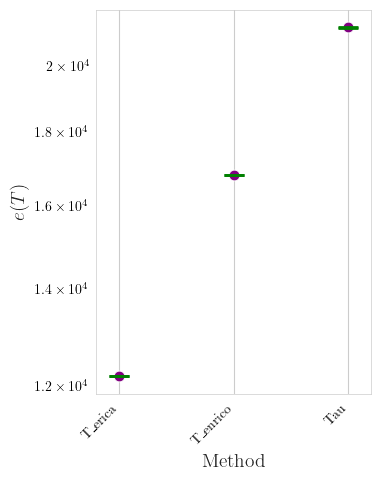


sample_radius_worst


100%|██████████| 20/20 [00:00<00:00, 23.34it/s]


Average e(τ) for T_erica: 12085.318 ± 0.726

Average e(τ) for T_enrico: 16715.214 ± 0.819

Average e(τ) for Tau: 21169.172 ± 1.343



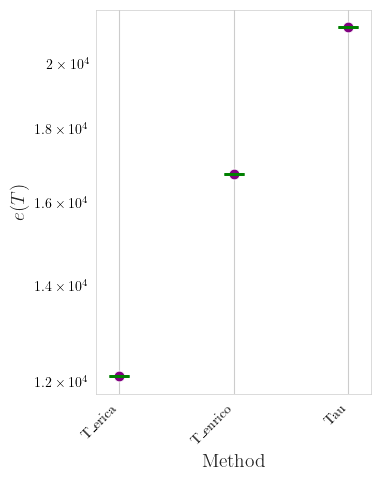


boundary_worst


100%|██████████| 20/20 [00:00<00:00, 31.75it/s]


Average e(τ) for T_erica: 12103.019 ± 0.000

Average e(τ) for T_enrico: 16737.663 ± 0.000

Average e(τ) for Tau: 21178.740 ± 0.000



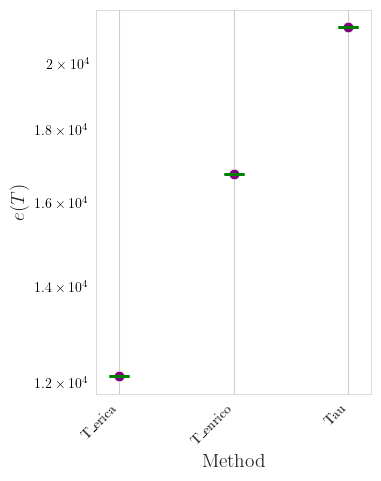


boundary_hat


100%|██████████| 20/20 [00:00<00:00, 21.80it/s]


Average e(τ) for T_erica: 12092.906 ± 27.622

Average e(τ) for T_enrico: 16720.193 ± 22.490

Average e(τ) for Tau: 21169.394 ± 28.394



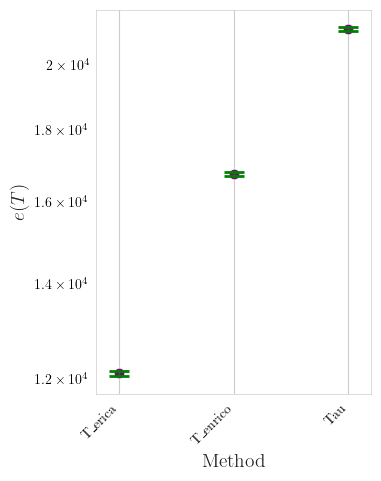


random_hat


100%|██████████| 20/20 [00:00<00:00, 22.09it/s]


Average e(τ) for T_erica: 12163.156 ± 0.786

Average e(τ) for T_enrico: 16779.514 ± 0.921

Average e(τ) for Tau: 21243.958 ± 2.304



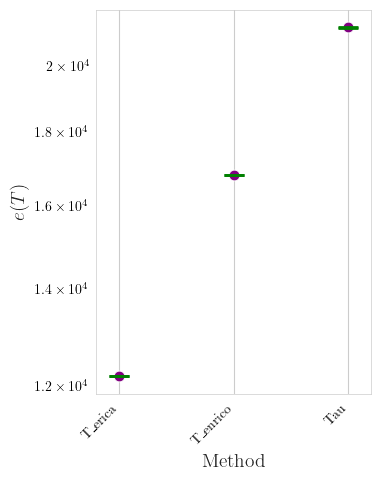


random_worst


100%|██████████| 20/20 [00:00<00:00, 23.10it/s]


Average e(τ) for T_erica: 12085.627 ± 0.768

Average e(τ) for T_enrico: 16715.575 ± 0.950

Average e(τ) for Tau: 21169.361 ± 1.433



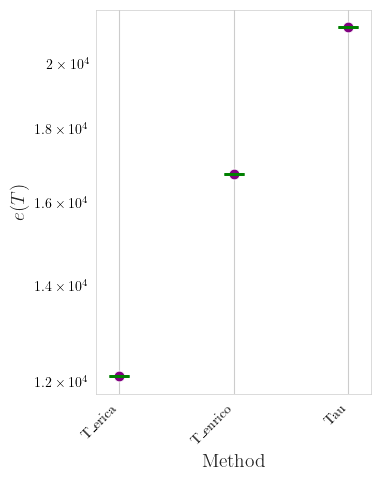


boundary_random_hat


100%|██████████| 20/20 [00:00<00:00, 23.04it/s]


Average e(τ) for T_erica: 12082.781 ± 21.752

Average e(τ) for T_enrico: 16712.485 ± 18.009

Average e(τ) for Tau: 21163.294 ± 25.067



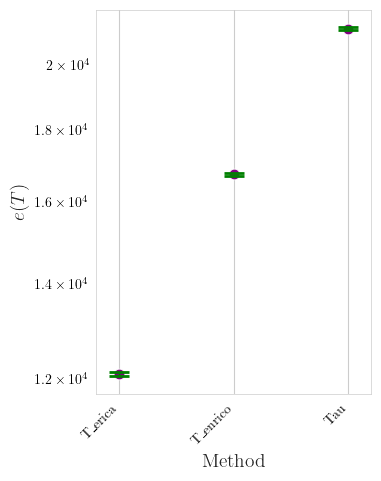


boundary_random_worst


100%|██████████| 20/20 [00:01<00:00, 17.35it/s]


Average e(τ) for T_erica: 12063.303 ± 7.318

Average e(τ) for T_enrico: 16695.792 ± 6.306

Average e(τ) for Tau: 21142.124 ± 9.537



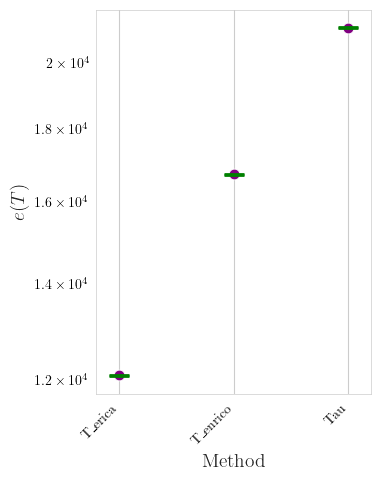


random_normal


100%|██████████| 20/20 [00:00<00:00, 24.95it/s]

Average e(τ) for T_erica: 12082.002 ± 0.957

Average e(τ) for T_enrico: 16712.033 ± 1.107

Average e(τ) for Tau: 21163.708 ± 1.161



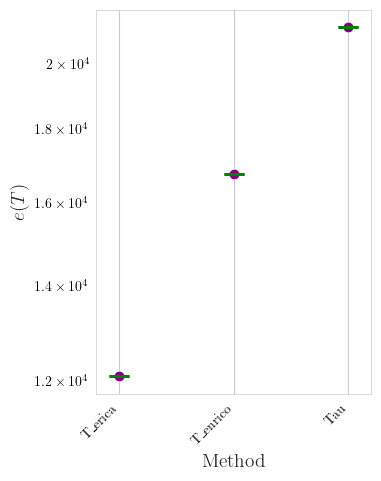

In [106]:
for pert_type in pert_types:
    print(pert_type)
    abstraction_error = {name: [] for name in methods.keys()}

    for iter_num in tqdm(range(num_iter)): 

        pert_L = generate_pertubation(pert_type, 'L', experiment, rad=4)
        pert_H = generate_pertubation(pert_type, 'H', experiment, rad=3)

        for name, T in methods.items():

            total = 0
            for iota in test_data.keys():
                base, abst = test_data[iota]

                if add_pertL:
                    base = base + pert_L 
                if add_pertH:
                    abst = abst + pert_H 
                    
                if lin_contaminationL:
                    base  = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                if lin_contaminationH:
                    abst  = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
                    
                base_norm = base / np.linalg.norm(base, 'fro')
                abst_norm = abst / np.linalg.norm(abst, 'fro')
                # Apply method and compute distance
                tau_base = base @ T.T
                dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
                total   += dist
                
            iter_avg = total / len(Ill)
            abstraction_error[name].append(iter_avg)
        
        final_abstraction_error = {}
    for name in methods:
        mean_e = np.mean(abstraction_error[name])
        std_e = np.std(abstraction_error[name])
        final_abstraction_error[name] = (mean_e, std_e * 1.96)
        print(f"Average e(τ) for {name}: {mean_e:.3f} ± {std_e:.3f}\n")

    evut.plot_abstraction_error(final_abstraction_error)
    print( )

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


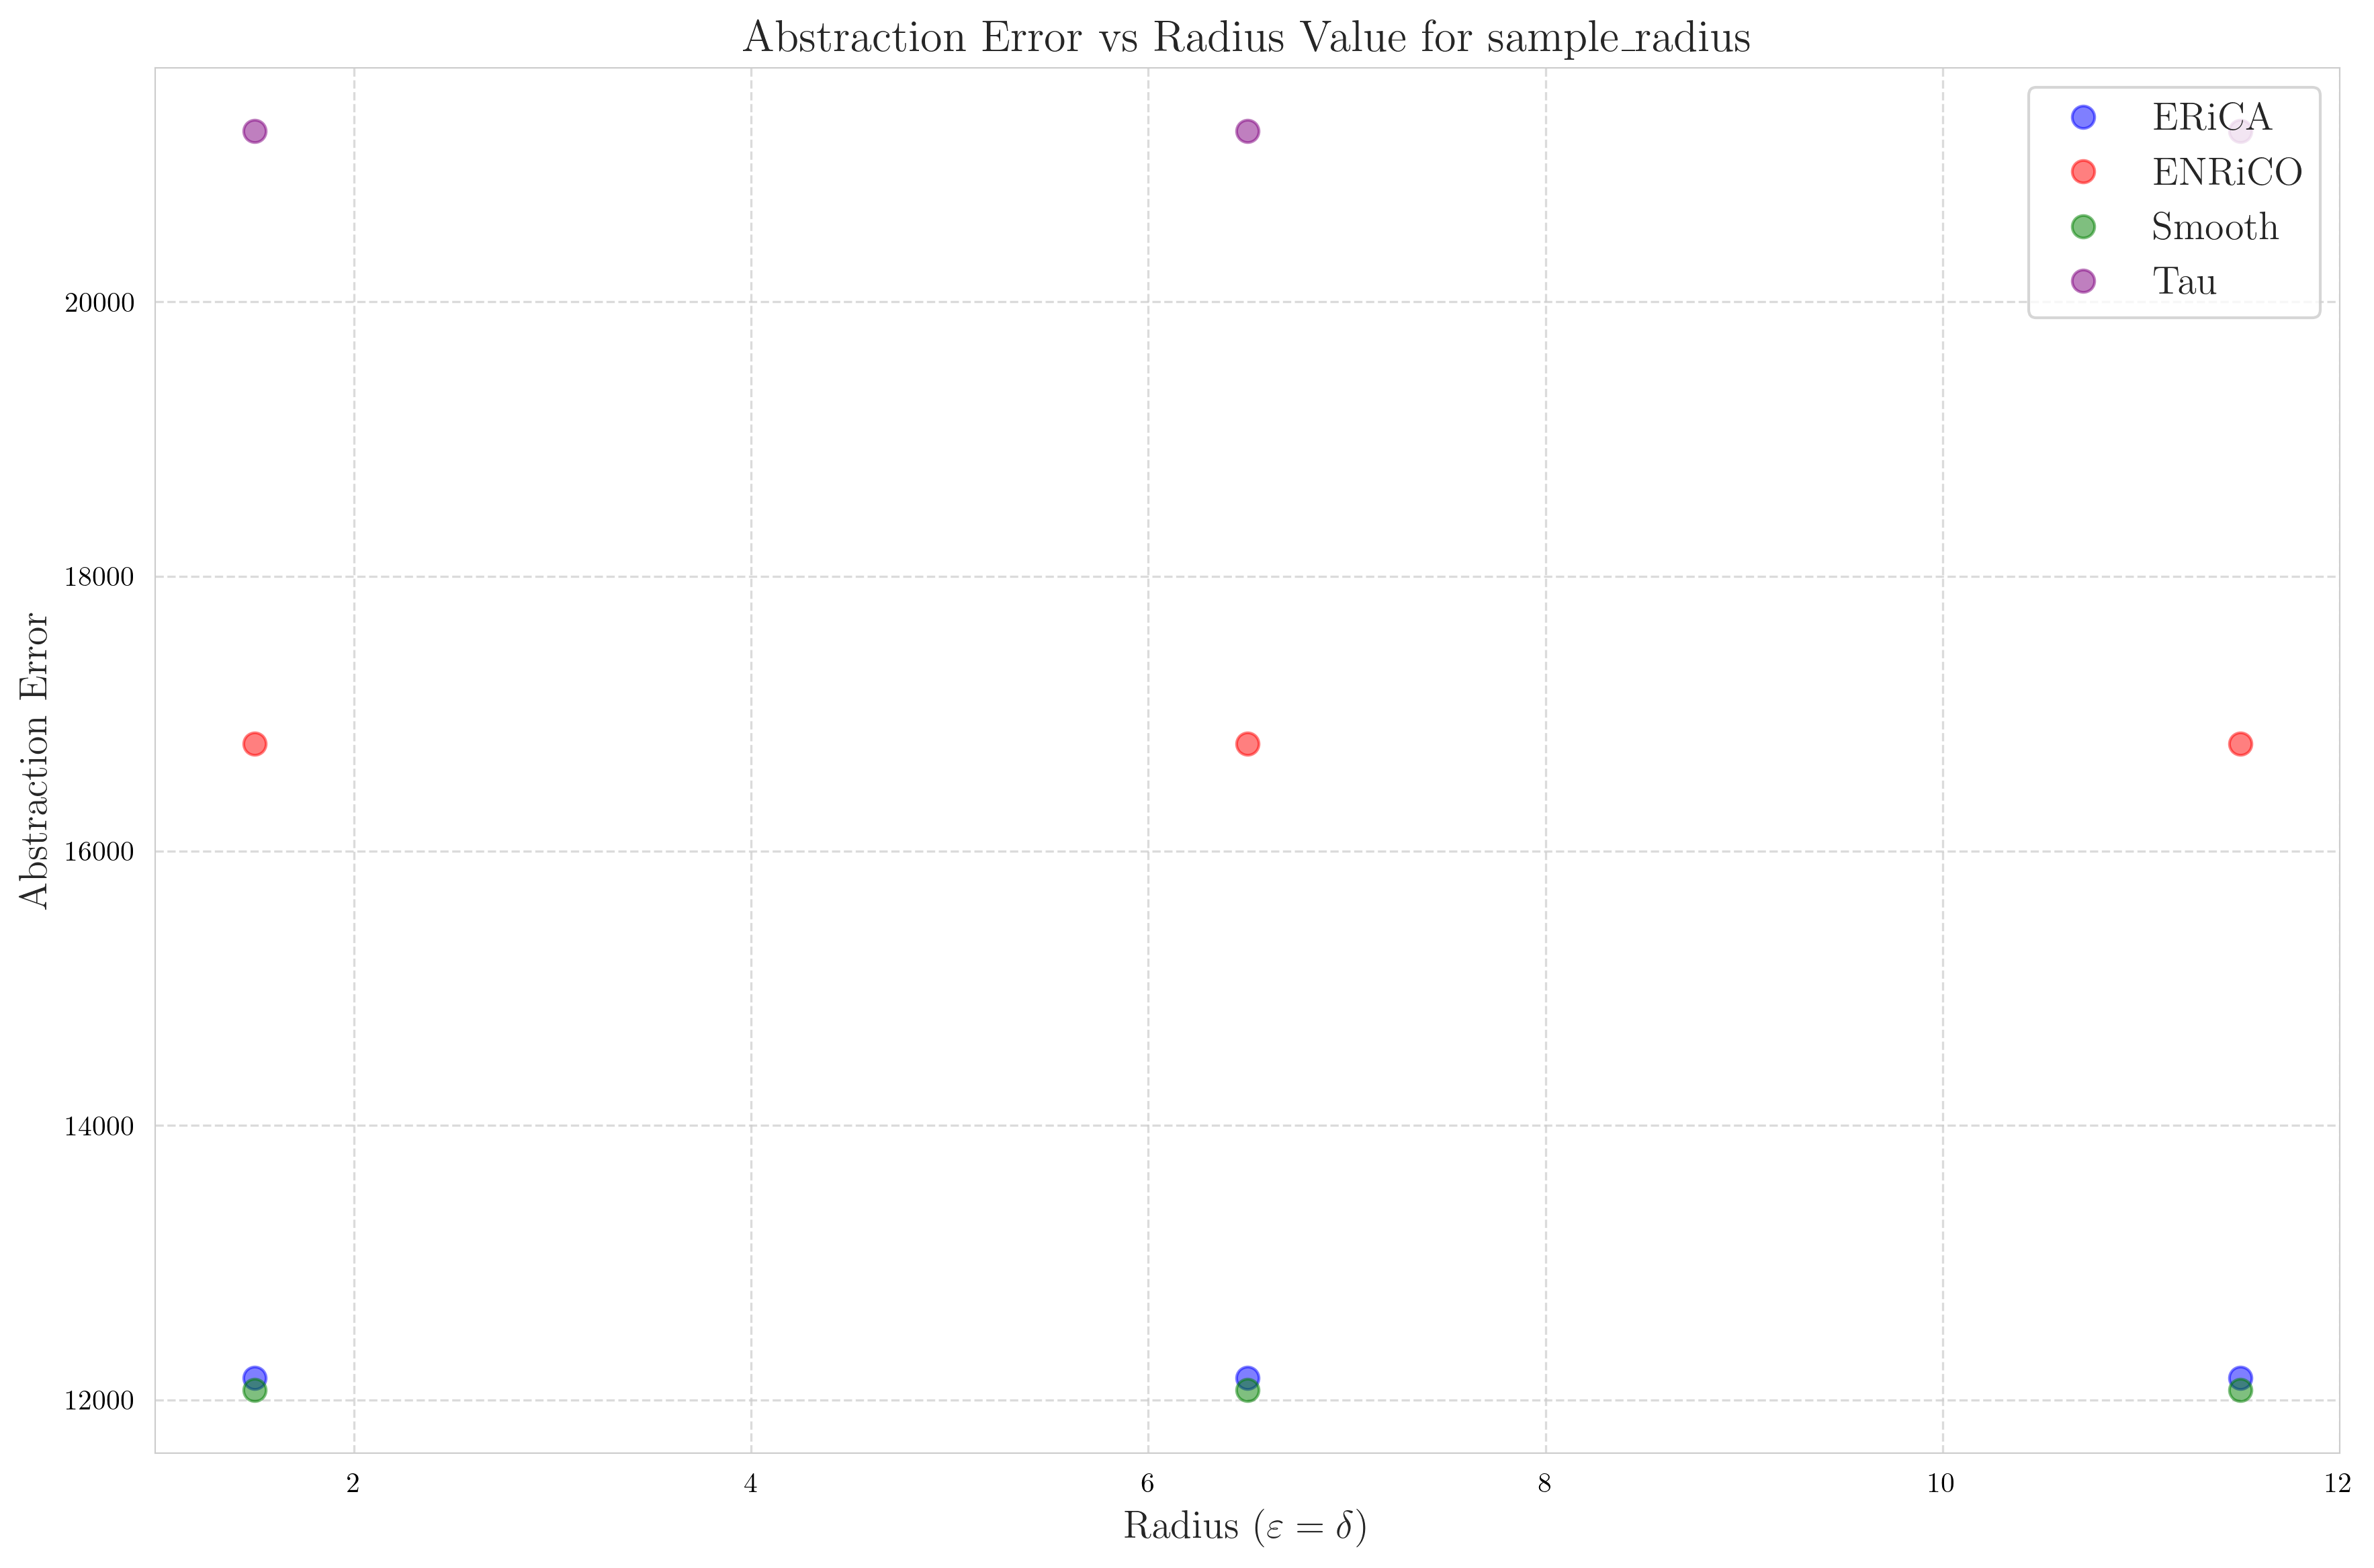


Best radius value for ERiCA:
Radius (ε=δ): 1.5
Mean error: 12162.8264 ± 2.9651

Best radius value for ENRiCO:
Radius (ε=δ): 1.5
Mean error: 16779.3884 ± 3.3354

Best radius value for Smooth:
Radius (ε=δ): 1.5
Mean error: 12071.5867 ± 2.9634

Best radius value for Tau:
Radius (ε=δ): 1.5
Mean error: 21243.5575 ± 4.5114



100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


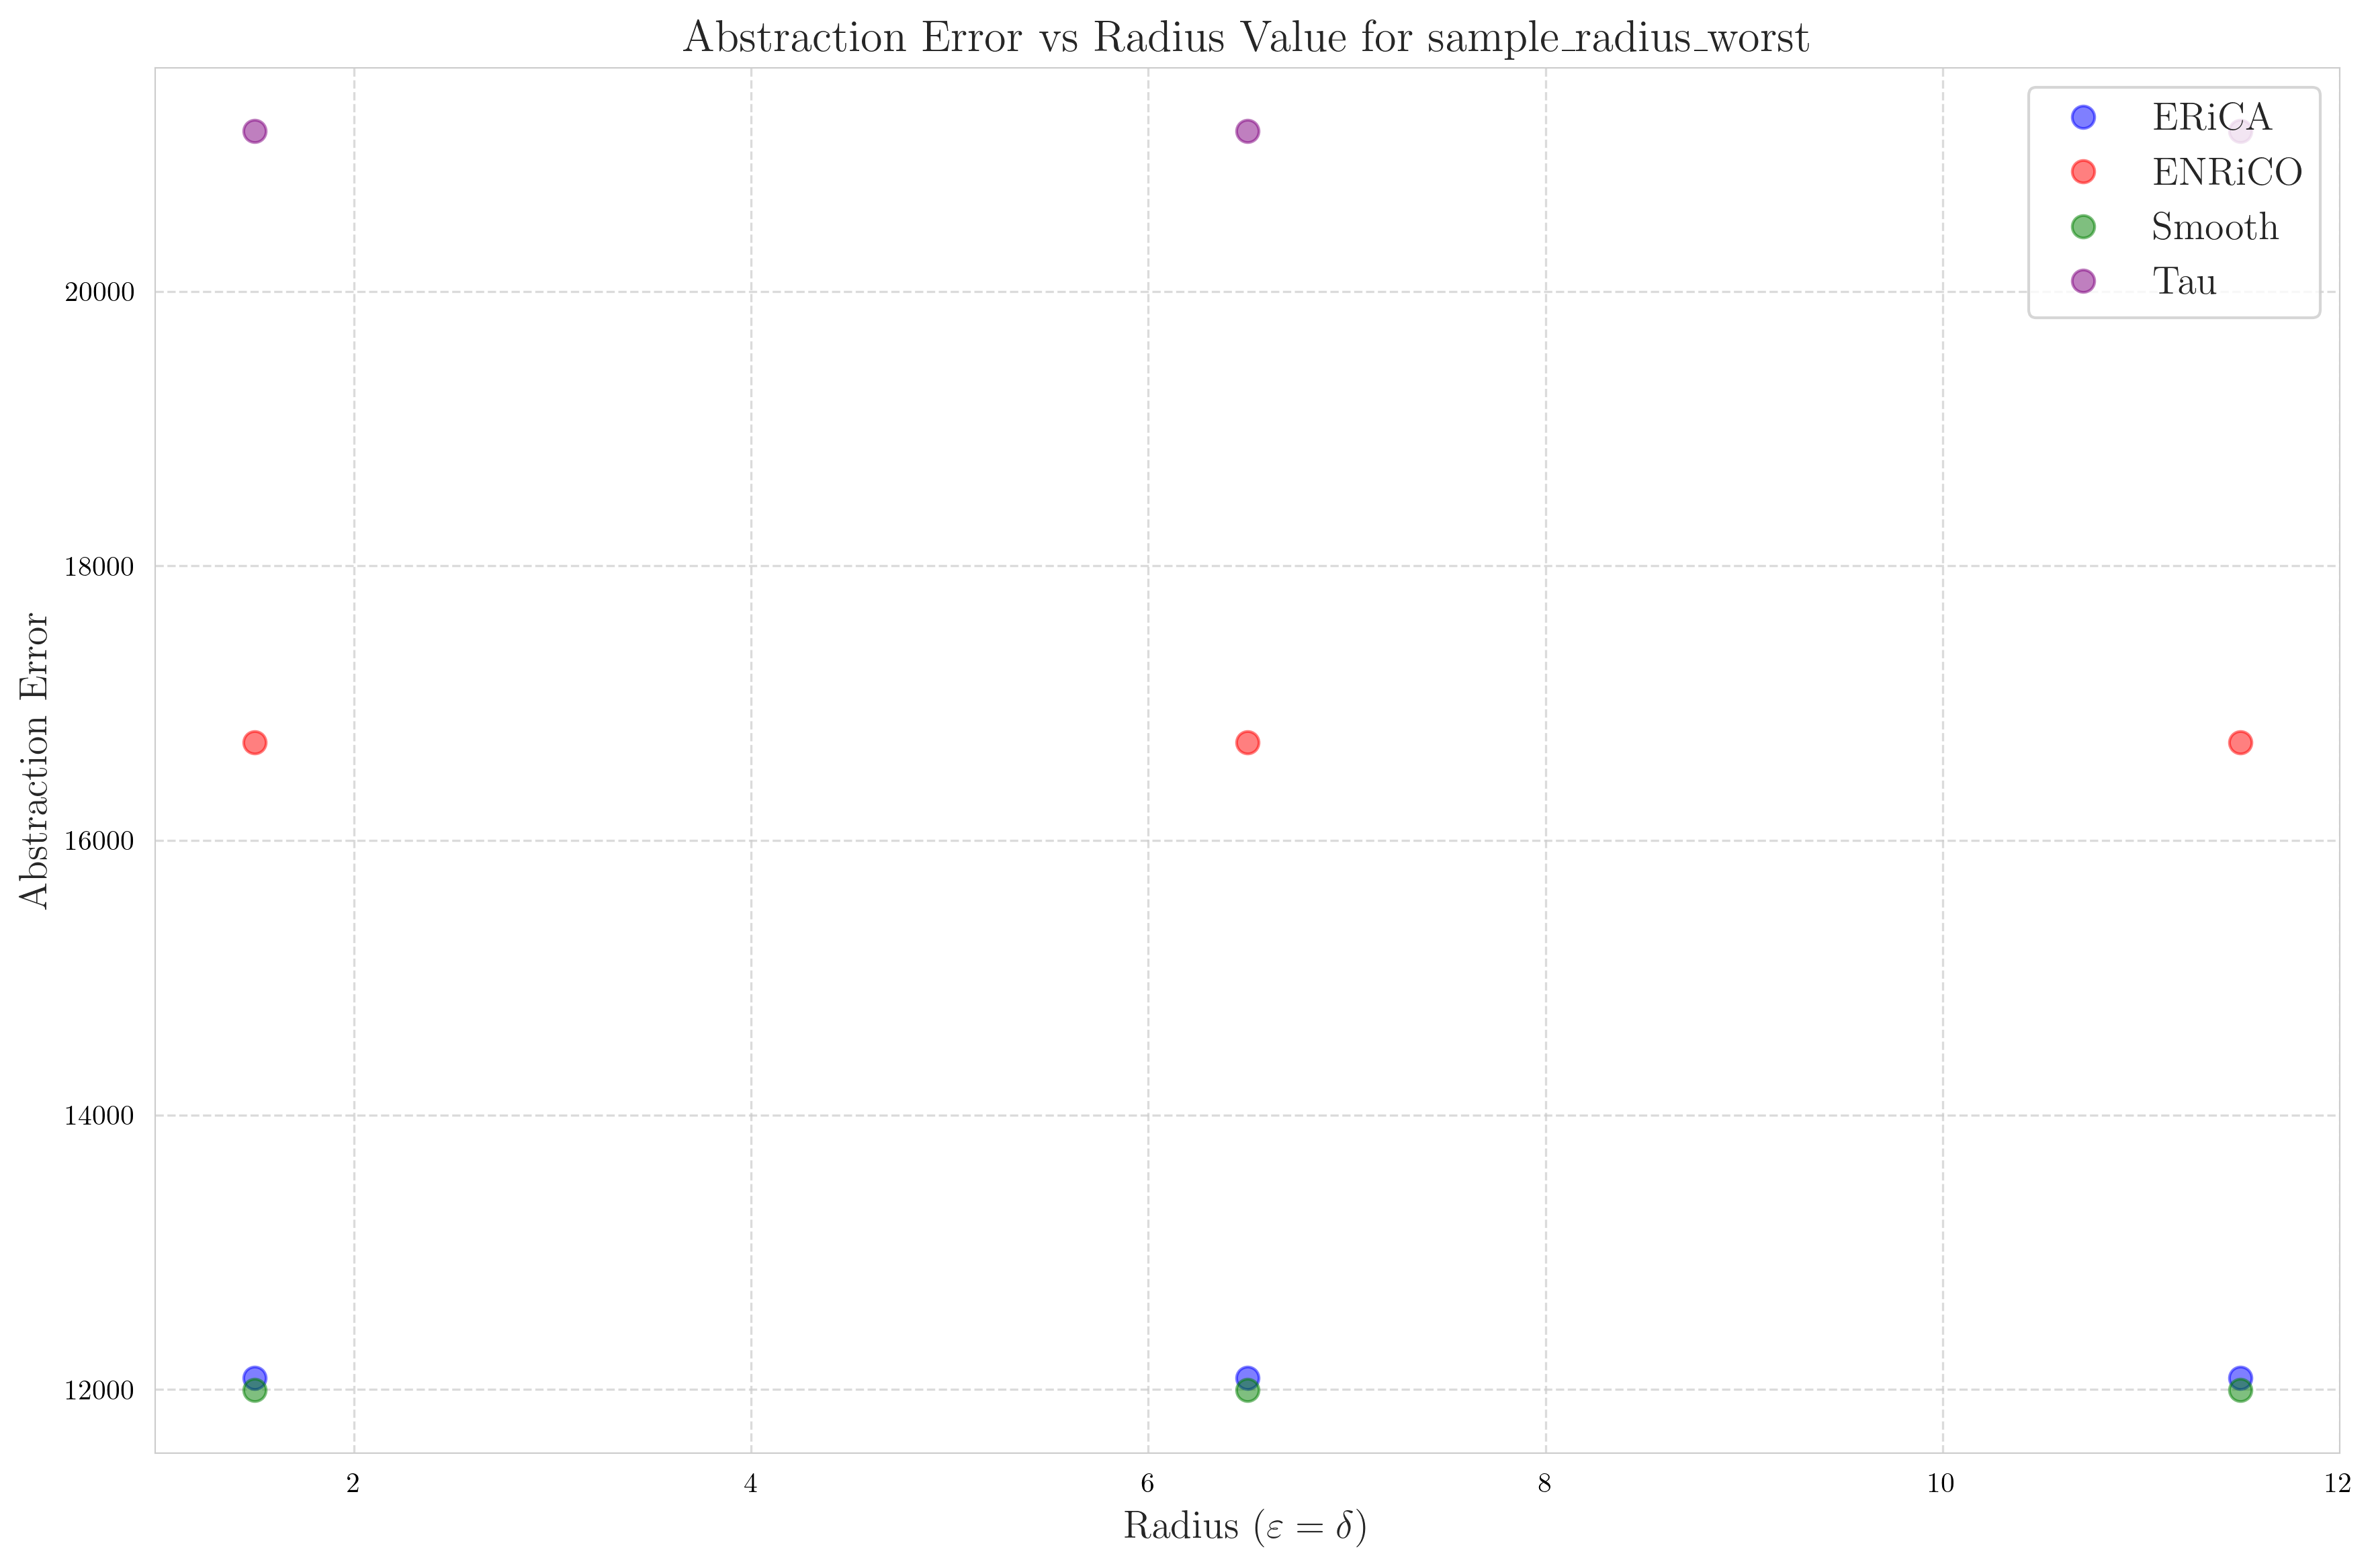


Best radius value for ERiCA:
Radius (ε=δ): 11.5
Mean error: 12085.4024 ± 1.5139

Best radius value for ENRiCO:
Radius (ε=δ): 6.5
Mean error: 16715.2410 ± 1.7731

Best radius value for Smooth:
Radius (ε=δ): 11.5
Mean error: 11993.7155 ± 1.5112

Best radius value for Tau:
Radius (ε=δ): 1.5
Mean error: 21168.8456 ± 2.5645



100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


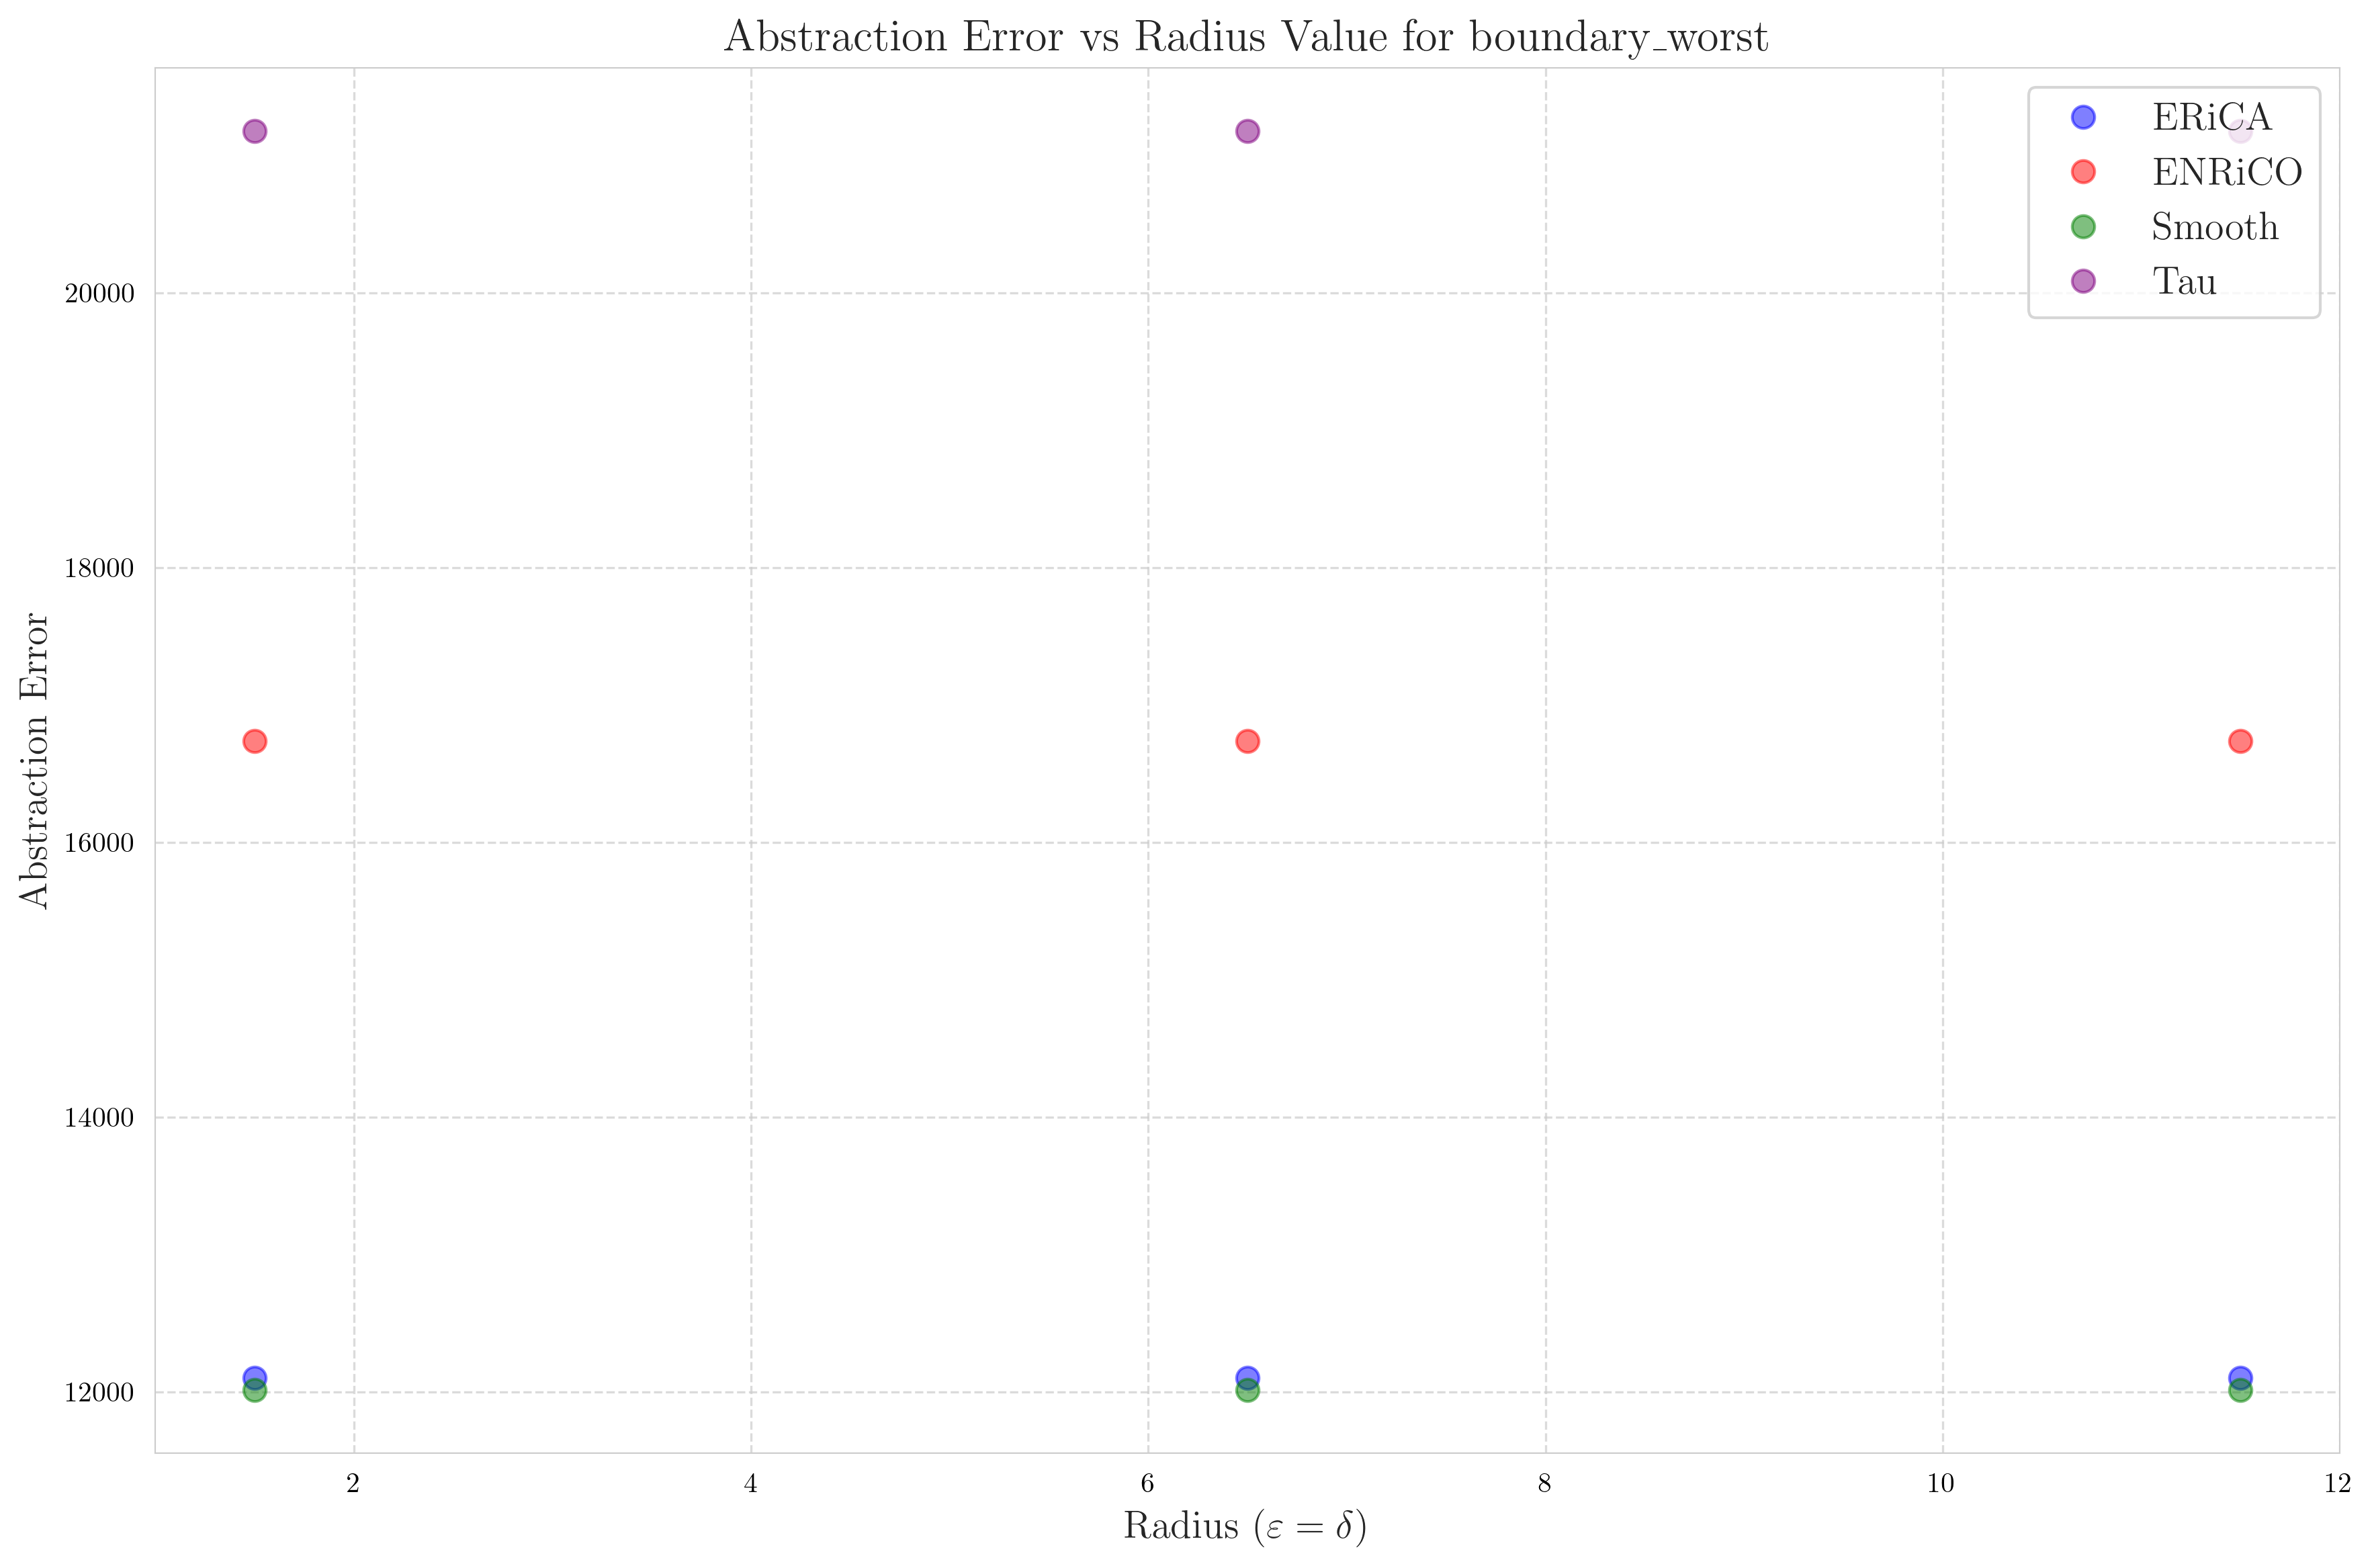


Best radius value for ERiCA:
Radius (ε=δ): 1.5
Mean error: 12103.0193 ± 0.0000

Best radius value for ENRiCO:
Radius (ε=δ): 1.5
Mean error: 16737.6627 ± 0.0000

Best radius value for Smooth:
Radius (ε=δ): 1.5
Mean error: 12011.2769 ± 0.0000

Best radius value for Tau:
Radius (ε=δ): 1.5
Mean error: 21178.7402 ± 0.0000



 67%|██████▋   | 2/3 [00:01<00:00,  1.00it/s]


KeyboardInterrupt: 

In [110]:
for pert_type in pert_types:
    pert_typeL = pert_type
    pert_typeH = pert_type
    # Define the grid of radii to test
    radius_values = np.arange(1.5, 14.5, 5).tolist()

    # Initialize dictionary to store results
    method_results = {
                        'ERiCA': {'T': T_erica, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))},
                        'ENRiCO': {'T': T_enrico, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))},
                        'Smooth': {'T': T_smooth, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))},
                        'Tau': {'T': Tau, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))}
                    }
    
    # method_results = {
    #     'ERiCA': {'T': T_erica, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))}}

    # Test each radius
    for i, radius in enumerate(tqdm(radius_values)):
        # Dictionary to store errors for current radius
        current_errors = {method: [] for method in method_results.keys()}
        
        for _ in range(num_iter):
            # Generate noise once per iteration
            pert_L = generate_pertubation(pert_typeL, 'L', experiment, rad=radius)
            pert_H = generate_pertubation(pert_typeH, 'H', experiment, rad=radius)

            for method_name, method_info in method_results.items():
                total = 0
                for iota in test_data.keys():
        
                    base, abst = test_data[iota]

                    if add_pertL:
                        base = base + pert_L 
                    if add_pertH:
                        abst = abst + pert_H 
                        
                    base_norm = base / np.linalg.norm(base, 'fro')
                    abst_norm = abst / np.linalg.norm(abst, 'fro')

                    tau_base = base @ method_info['T'].T
                    dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
                    total   += dist
            
                iter_avg = total / len(Ill)
                current_errors[method_name].append(iter_avg)

        # Store mean and std for all methods
        for method_name in method_results:
            method_results[method_name]['errors'][i] = np.mean(current_errors[method_name])
            method_results[method_name]['stds'][i] = np.std(current_errors[method_name])

    # Create plot
    plt.figure(figsize=(12, 8))

    colors = {'ERiCA': 'blue', 'ENRiCO': 'red', 'Smooth': 'green', 'Tau': 'purple'}
    for method_name, method_info in method_results.items():
        plt.plot(radius_values, method_info['errors'], 'o', 
                color=colors[method_name], 
                label=method_name, 
                alpha=0.5, 
                markersize=8) 

    plt.xlabel(r'Radius ($\varepsilon=\delta$)')
    plt.ylabel('Abstraction Error')
    plt.title(f'Abstraction Error vs Radius Value for {pert_type}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print best radius for all methods
    for method_name, method_info in method_results.items():
        best_idx = np.argmin(method_info['errors'])
        print(f"\nBest radius value for {method_name}:")
        print(f"Radius (ε=δ): {radius_values[best_idx]}")
        print(f"Mean error: {method_info['errors'][best_idx]:.4f} ± {method_info['stds'][best_idx]*1.96:.4f}")
    print( )

100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


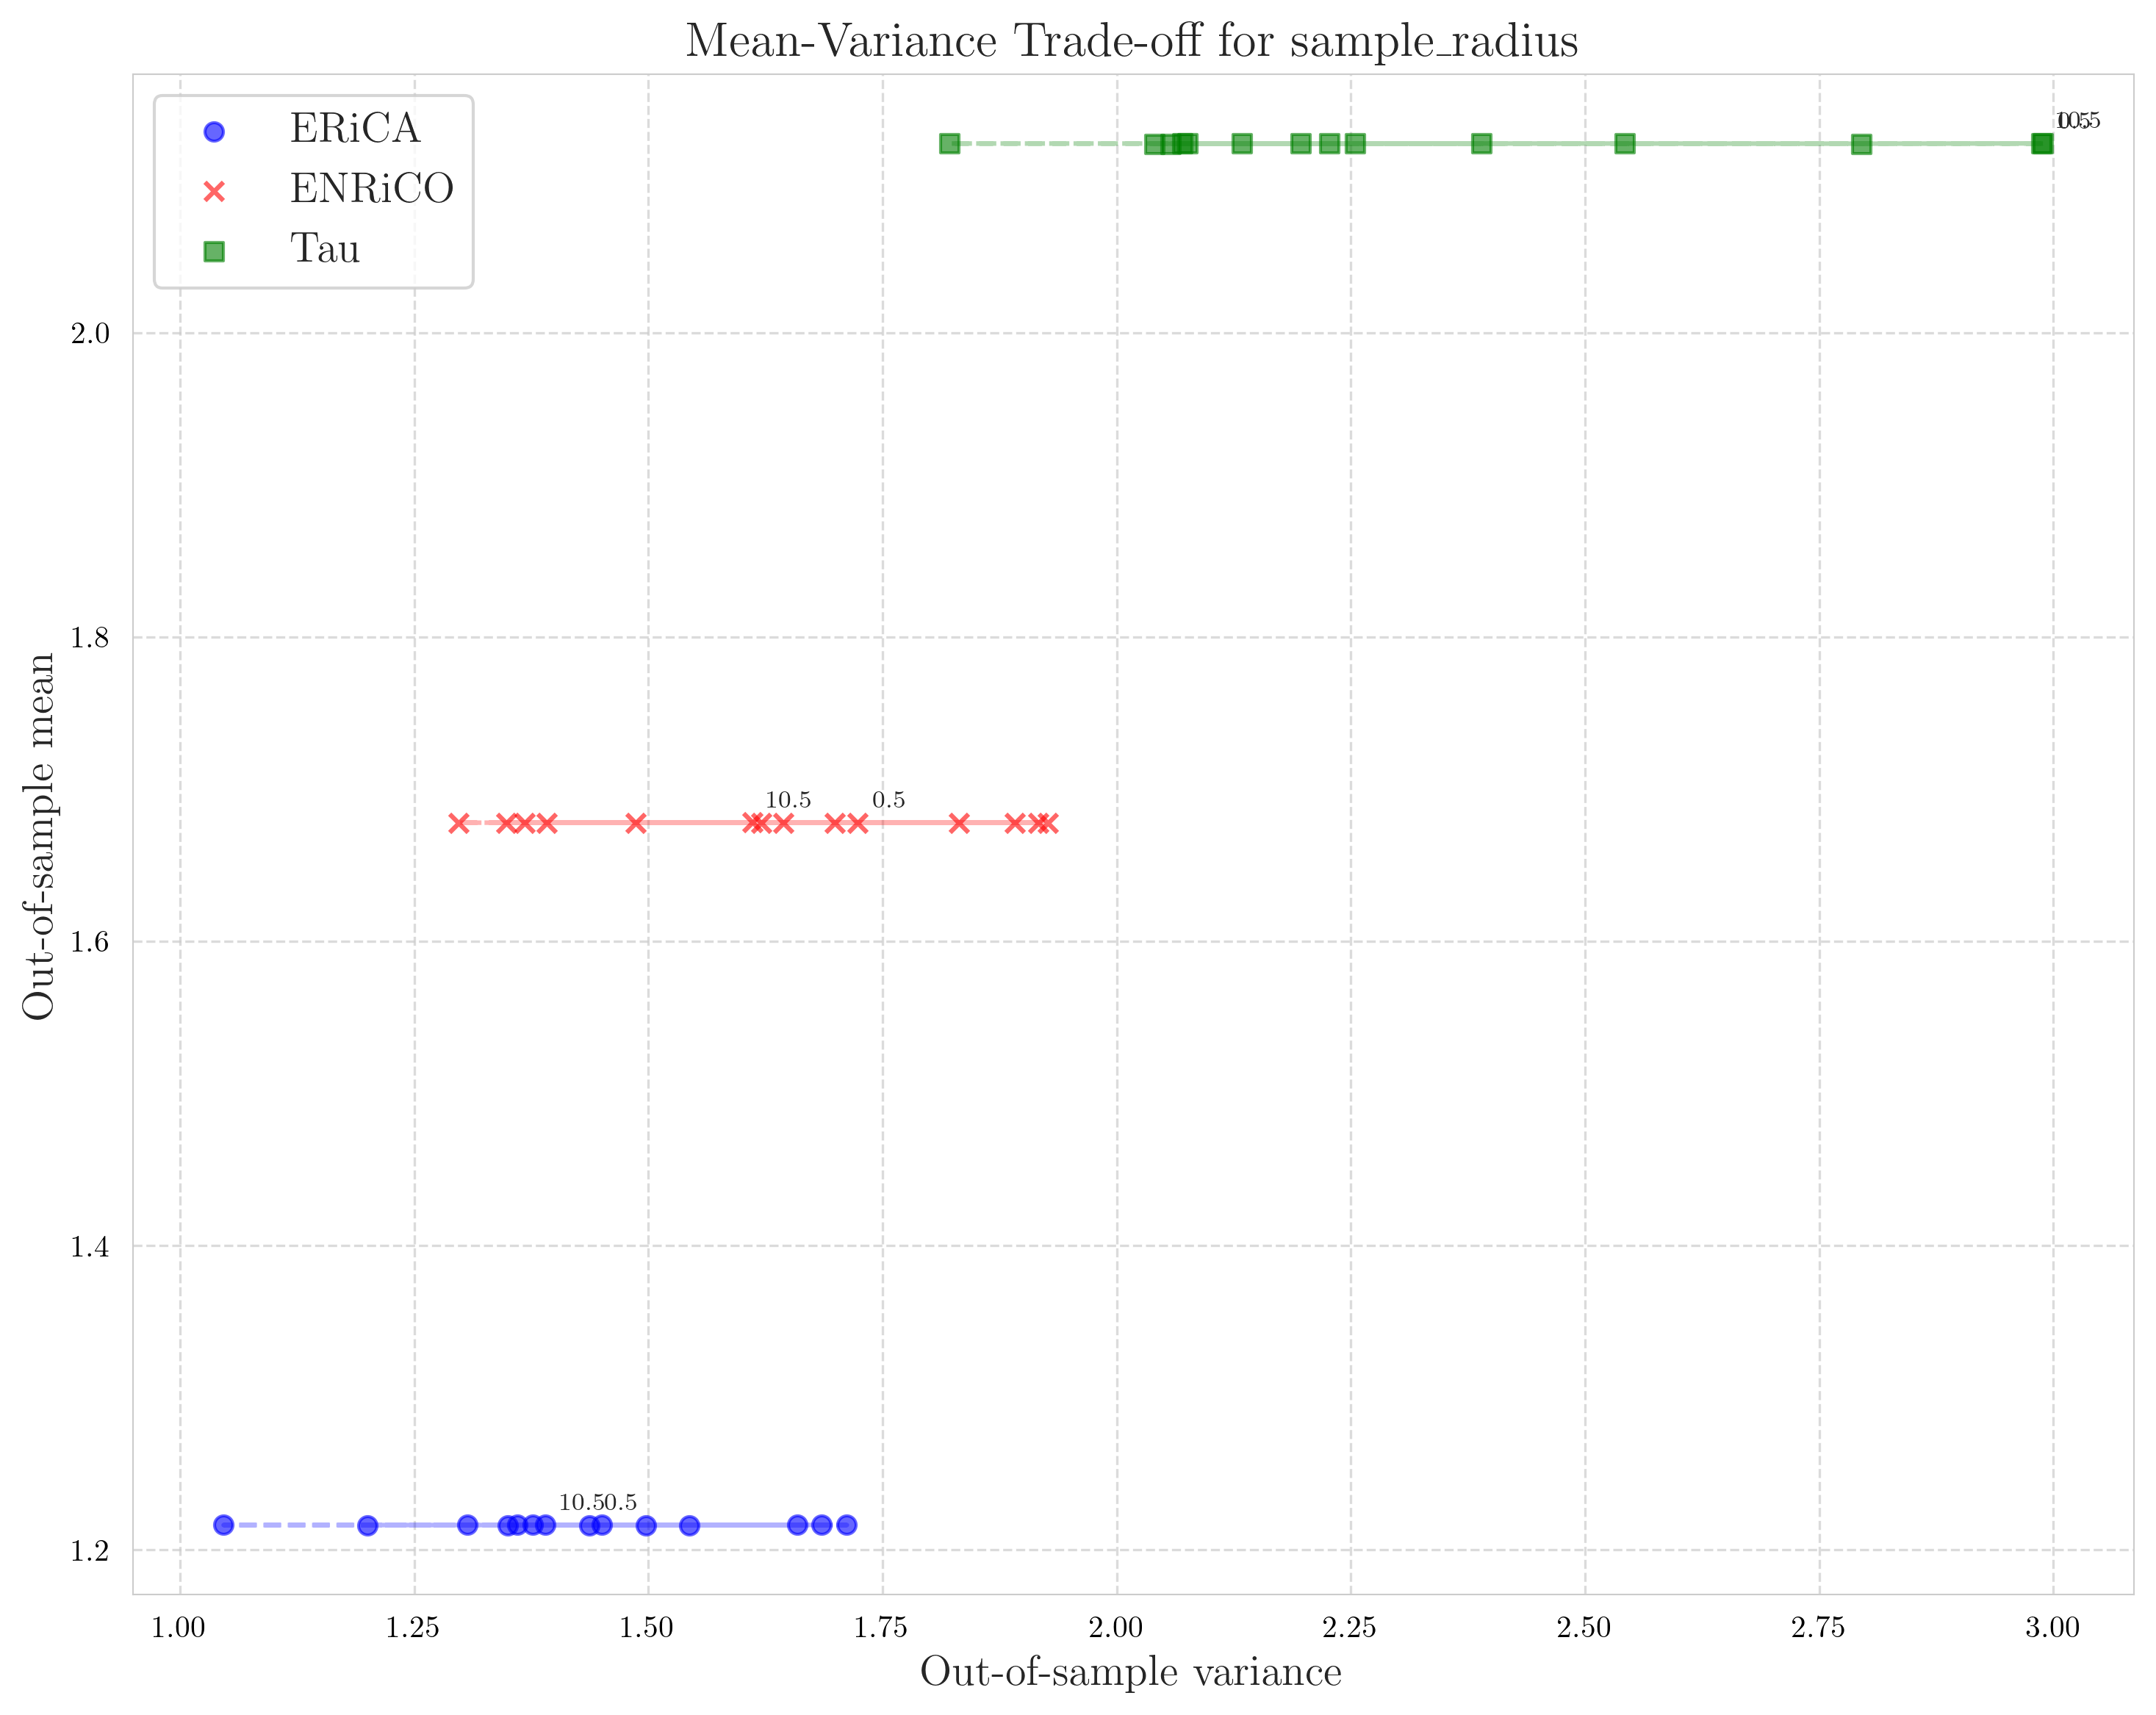

100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


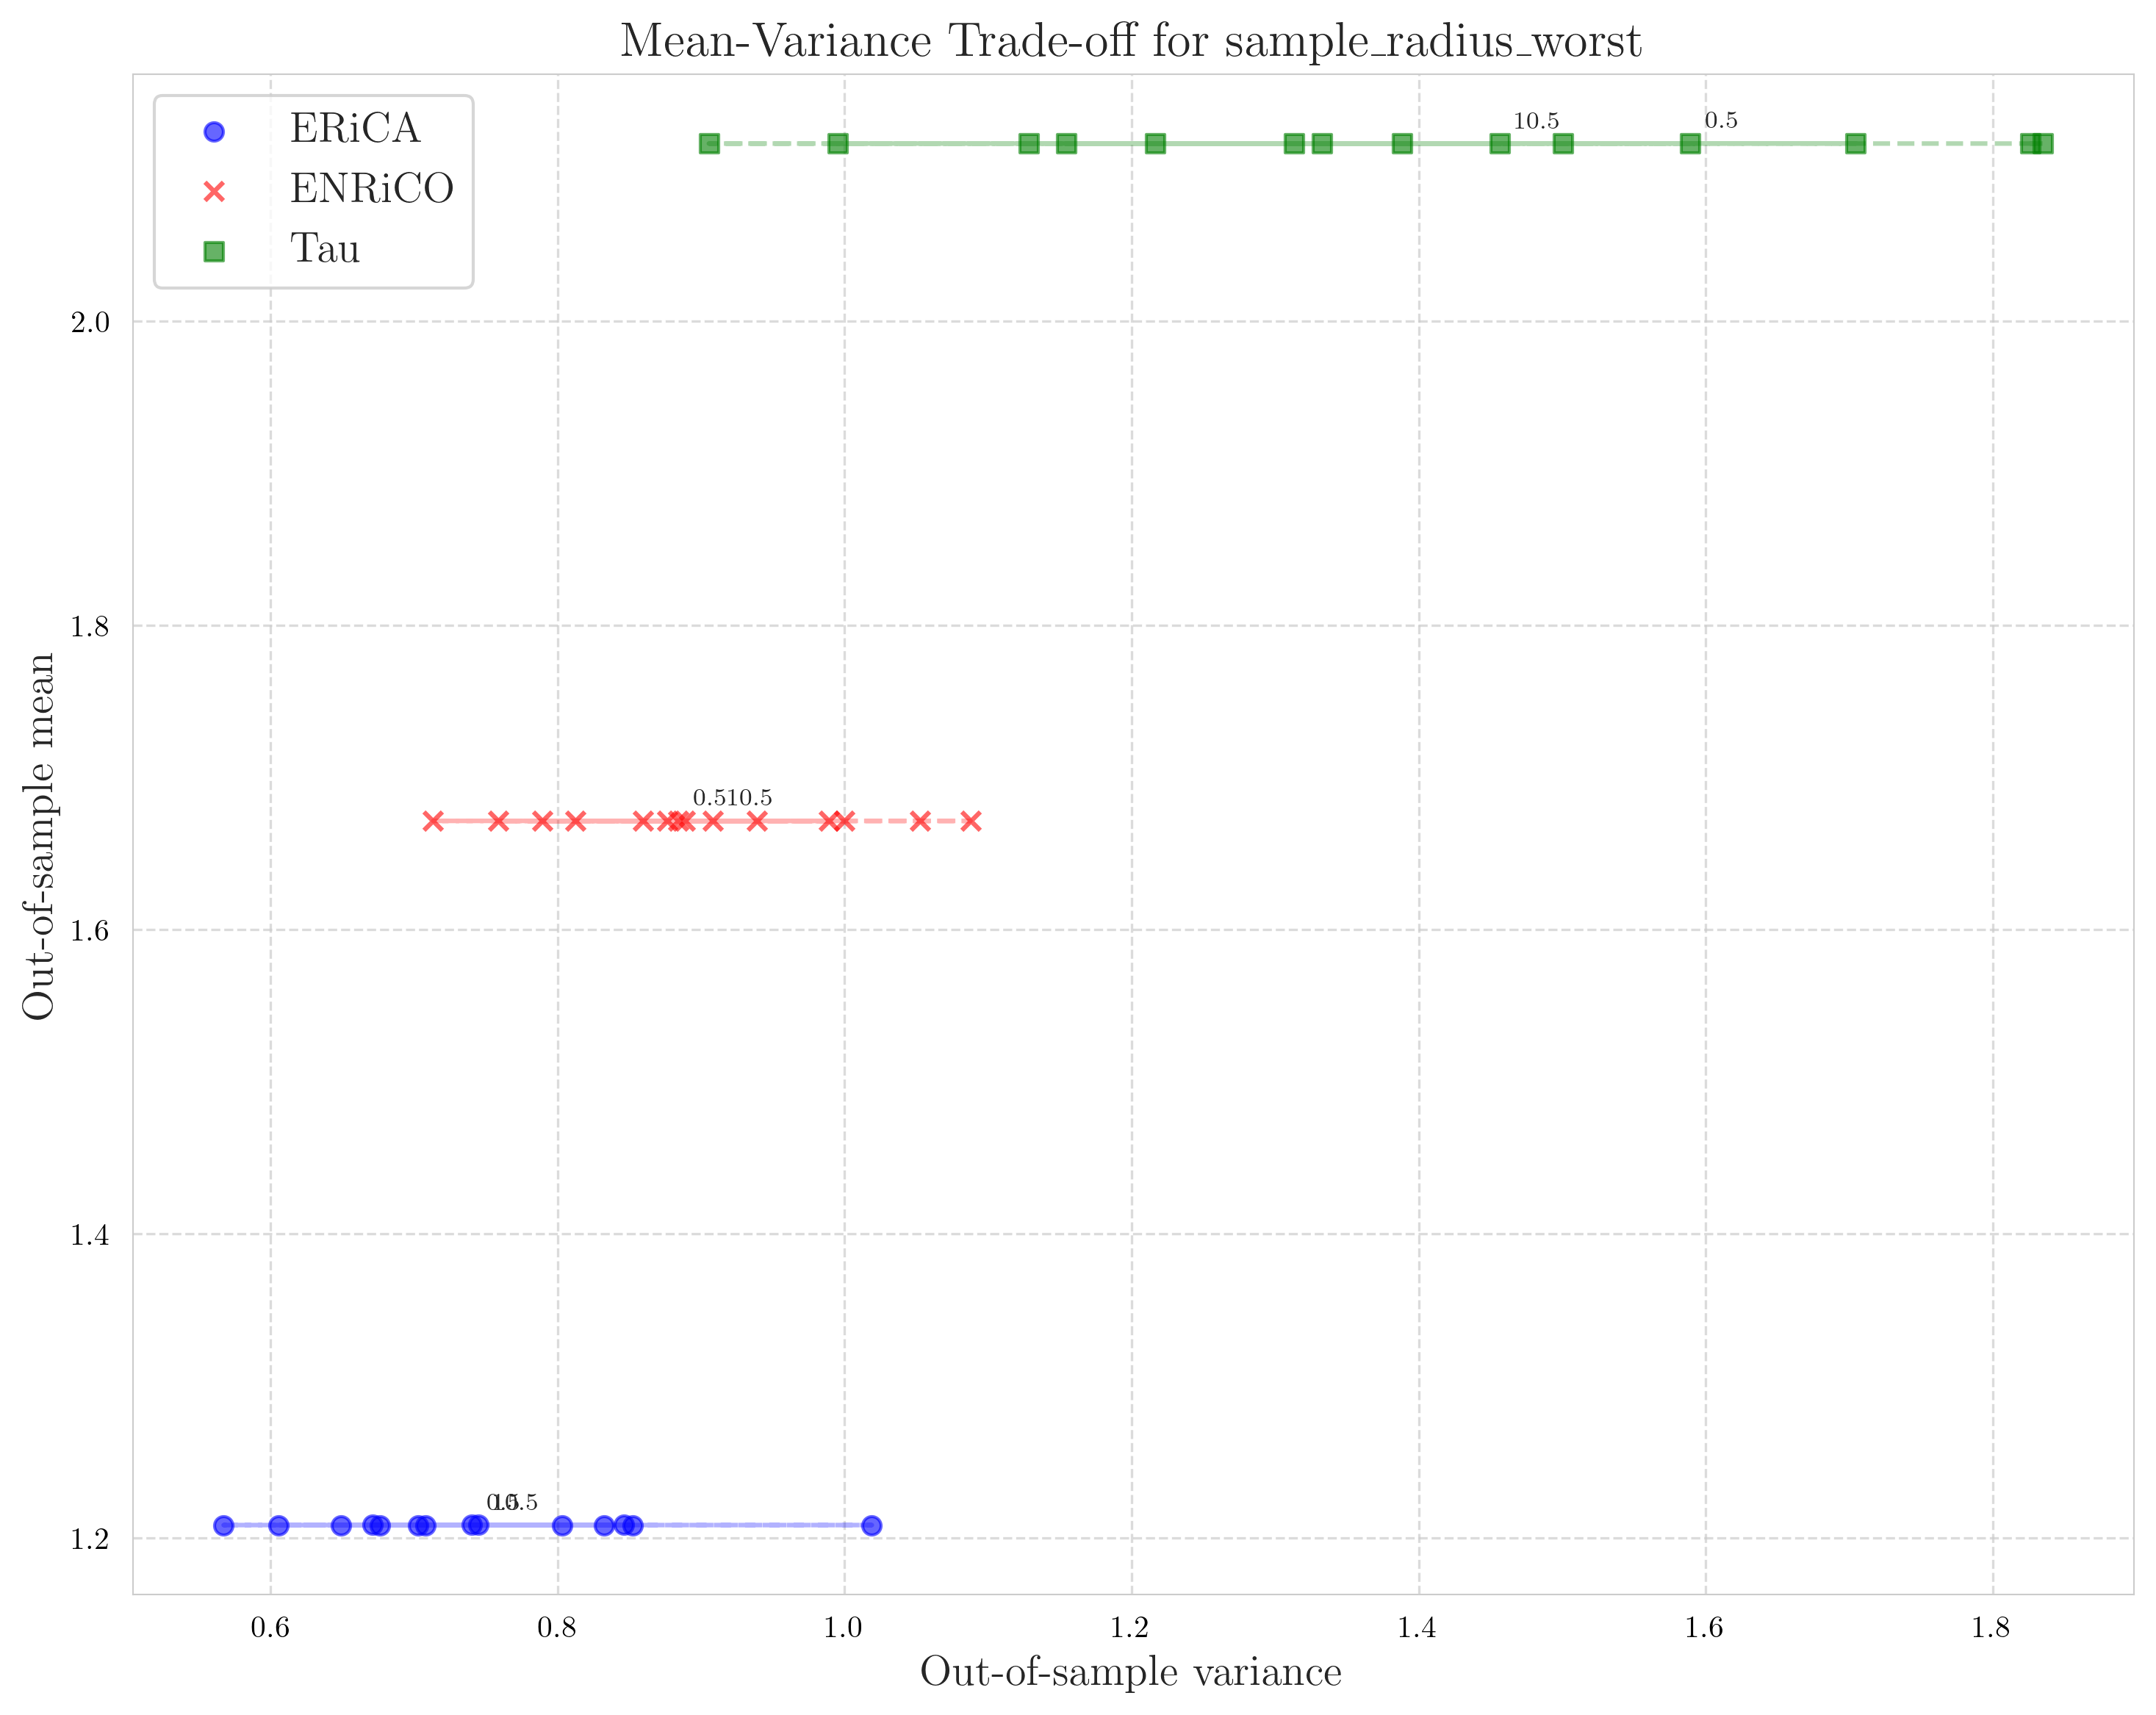

100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


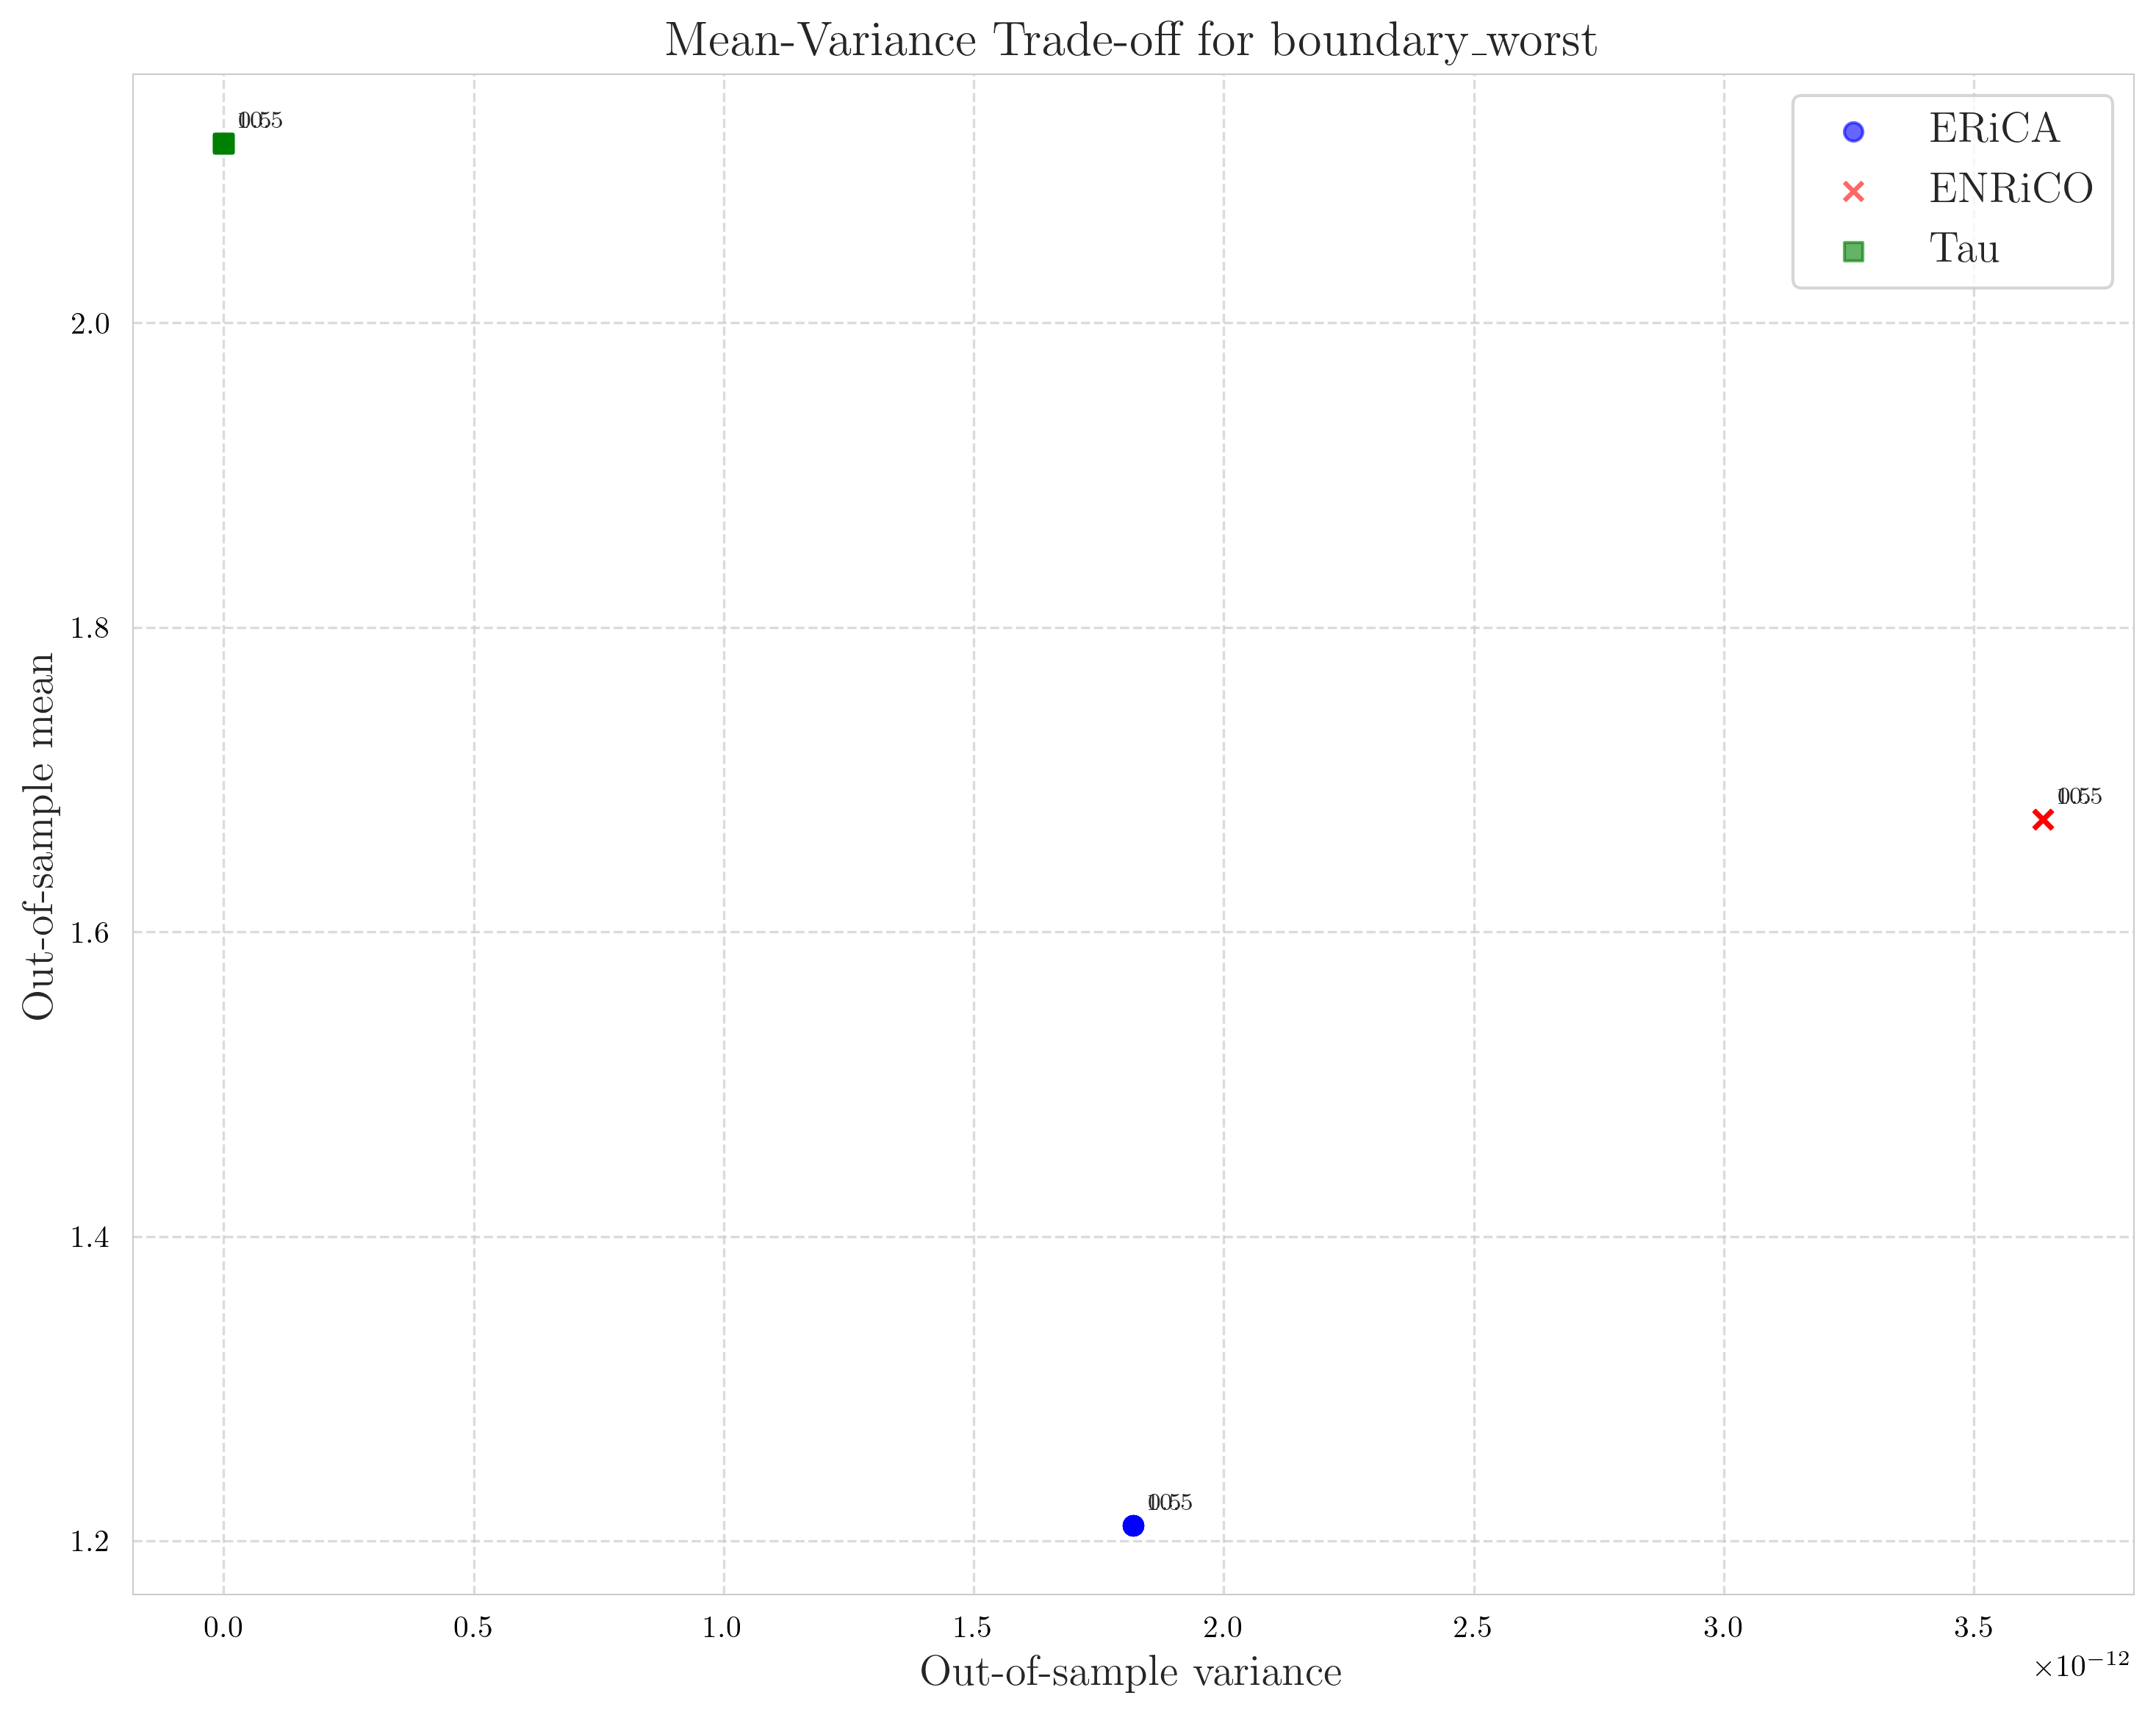

100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


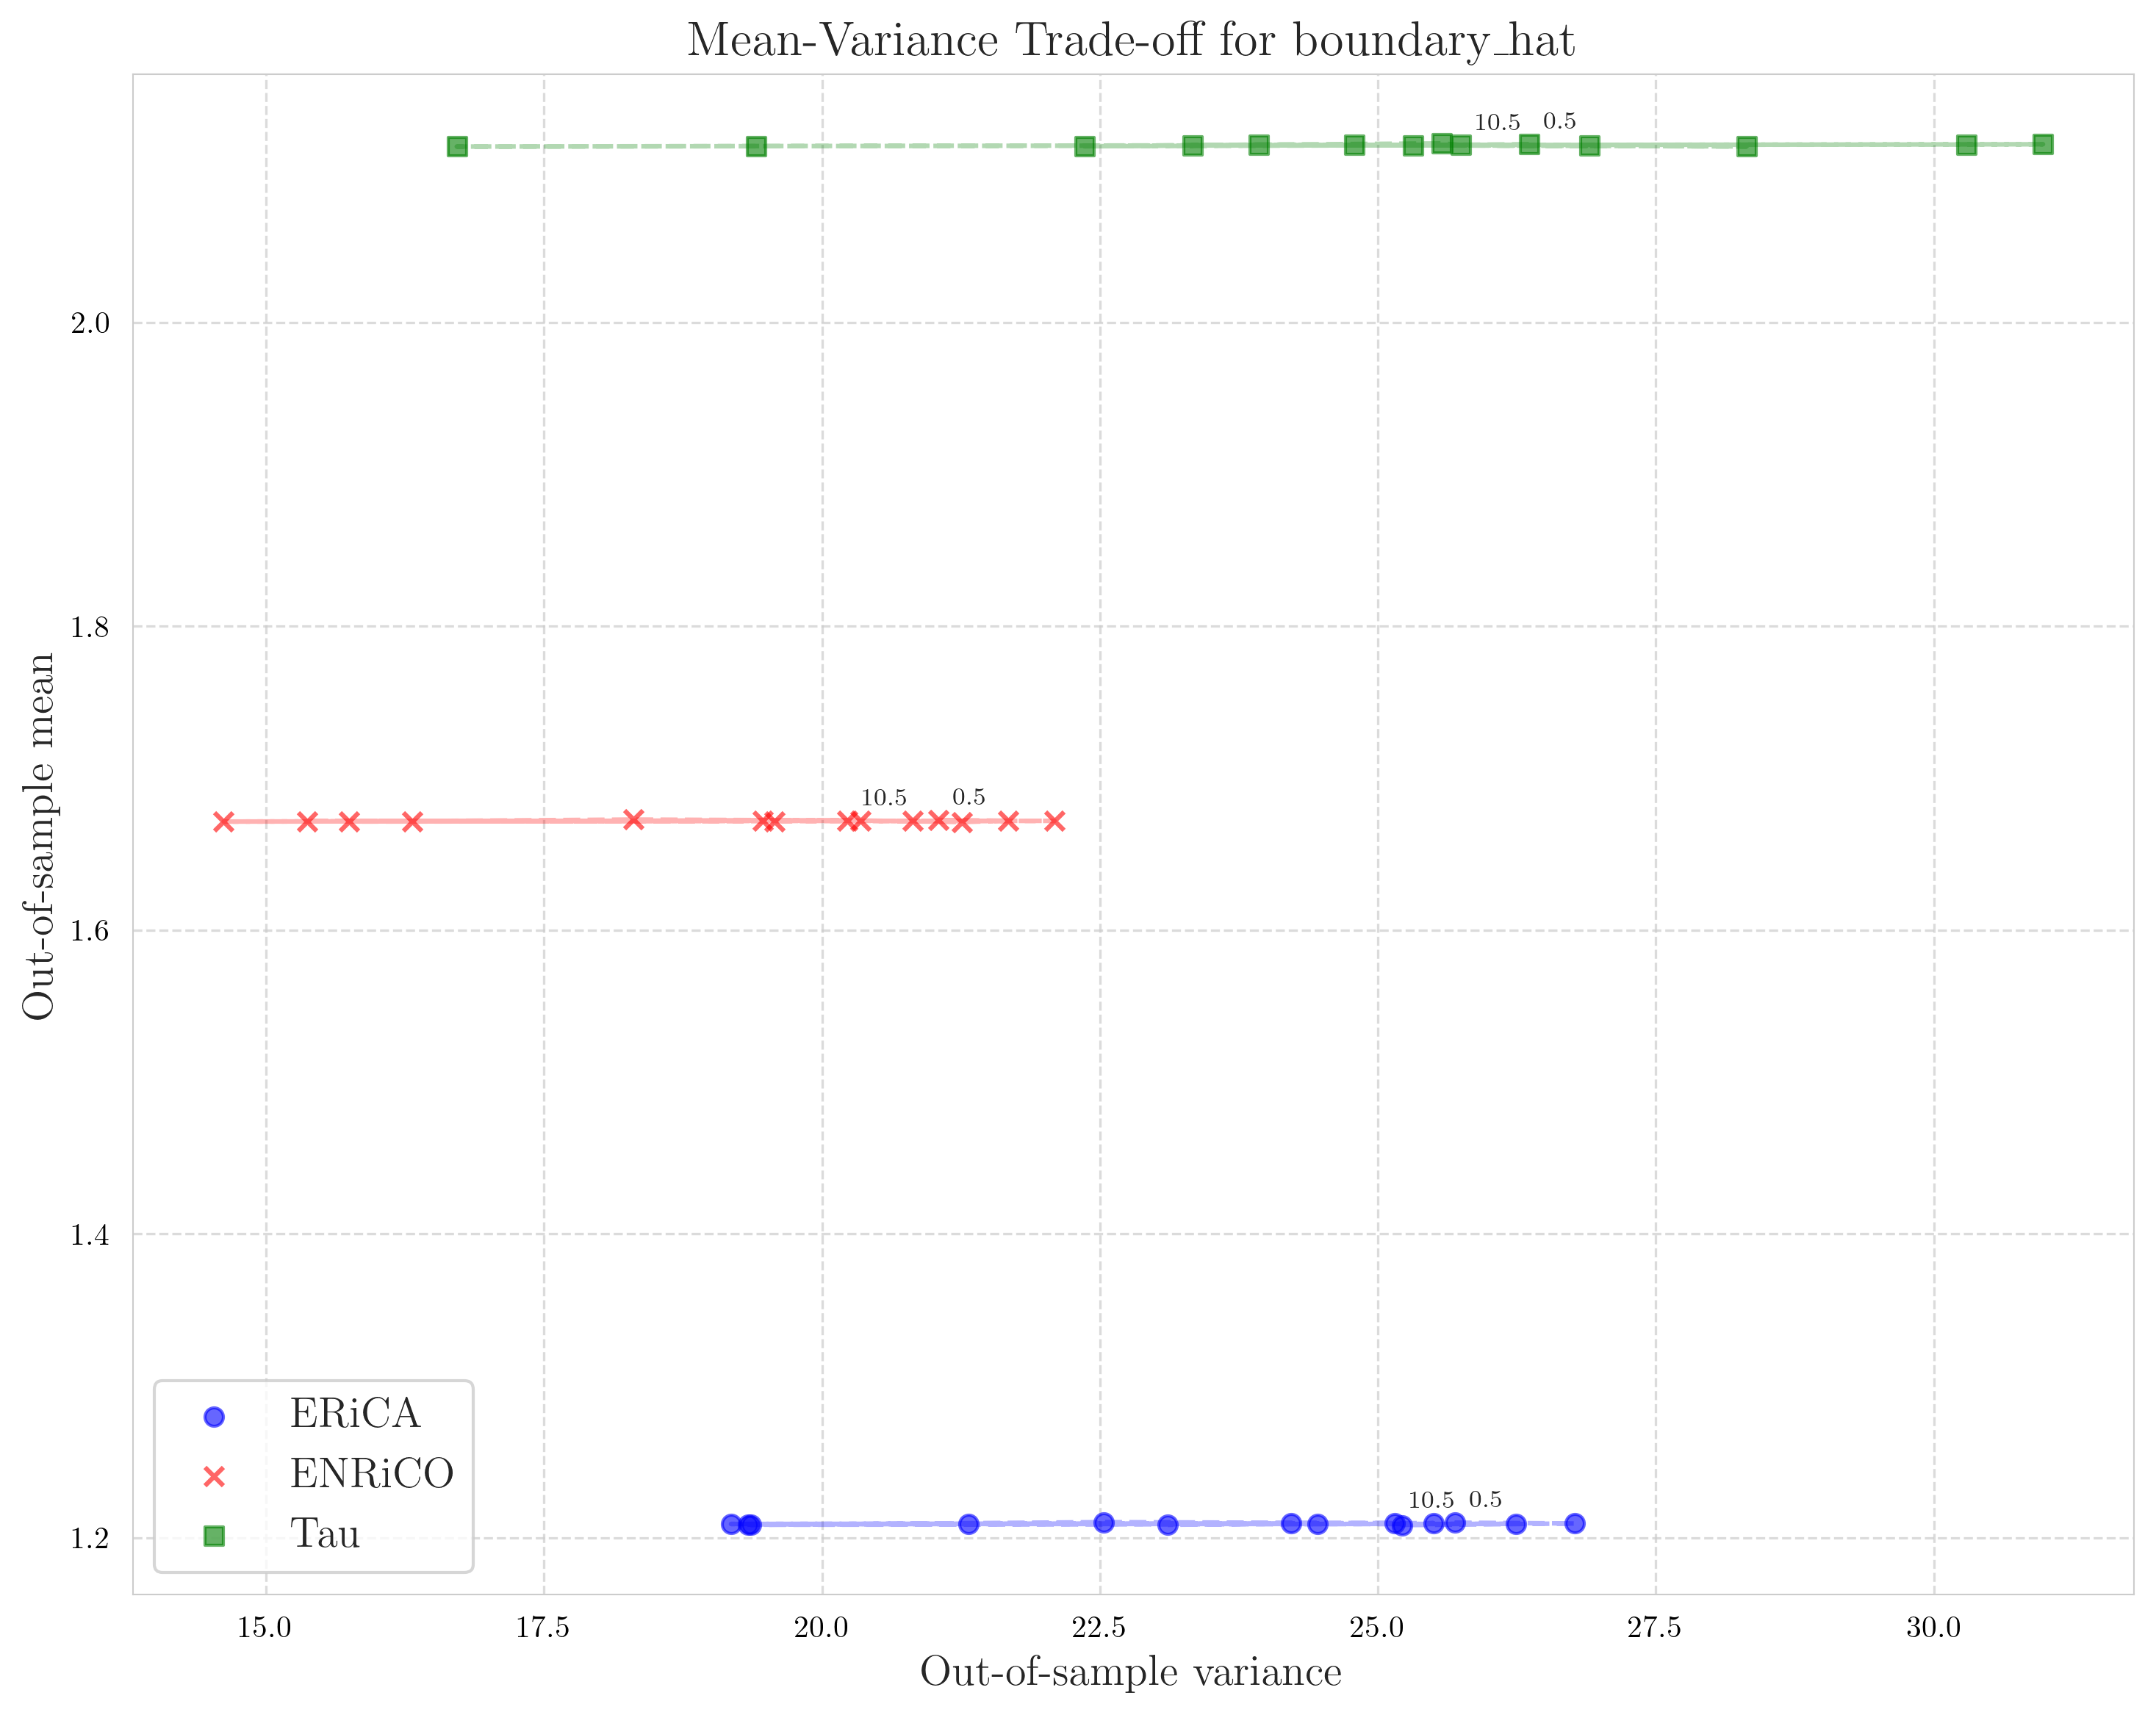

100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


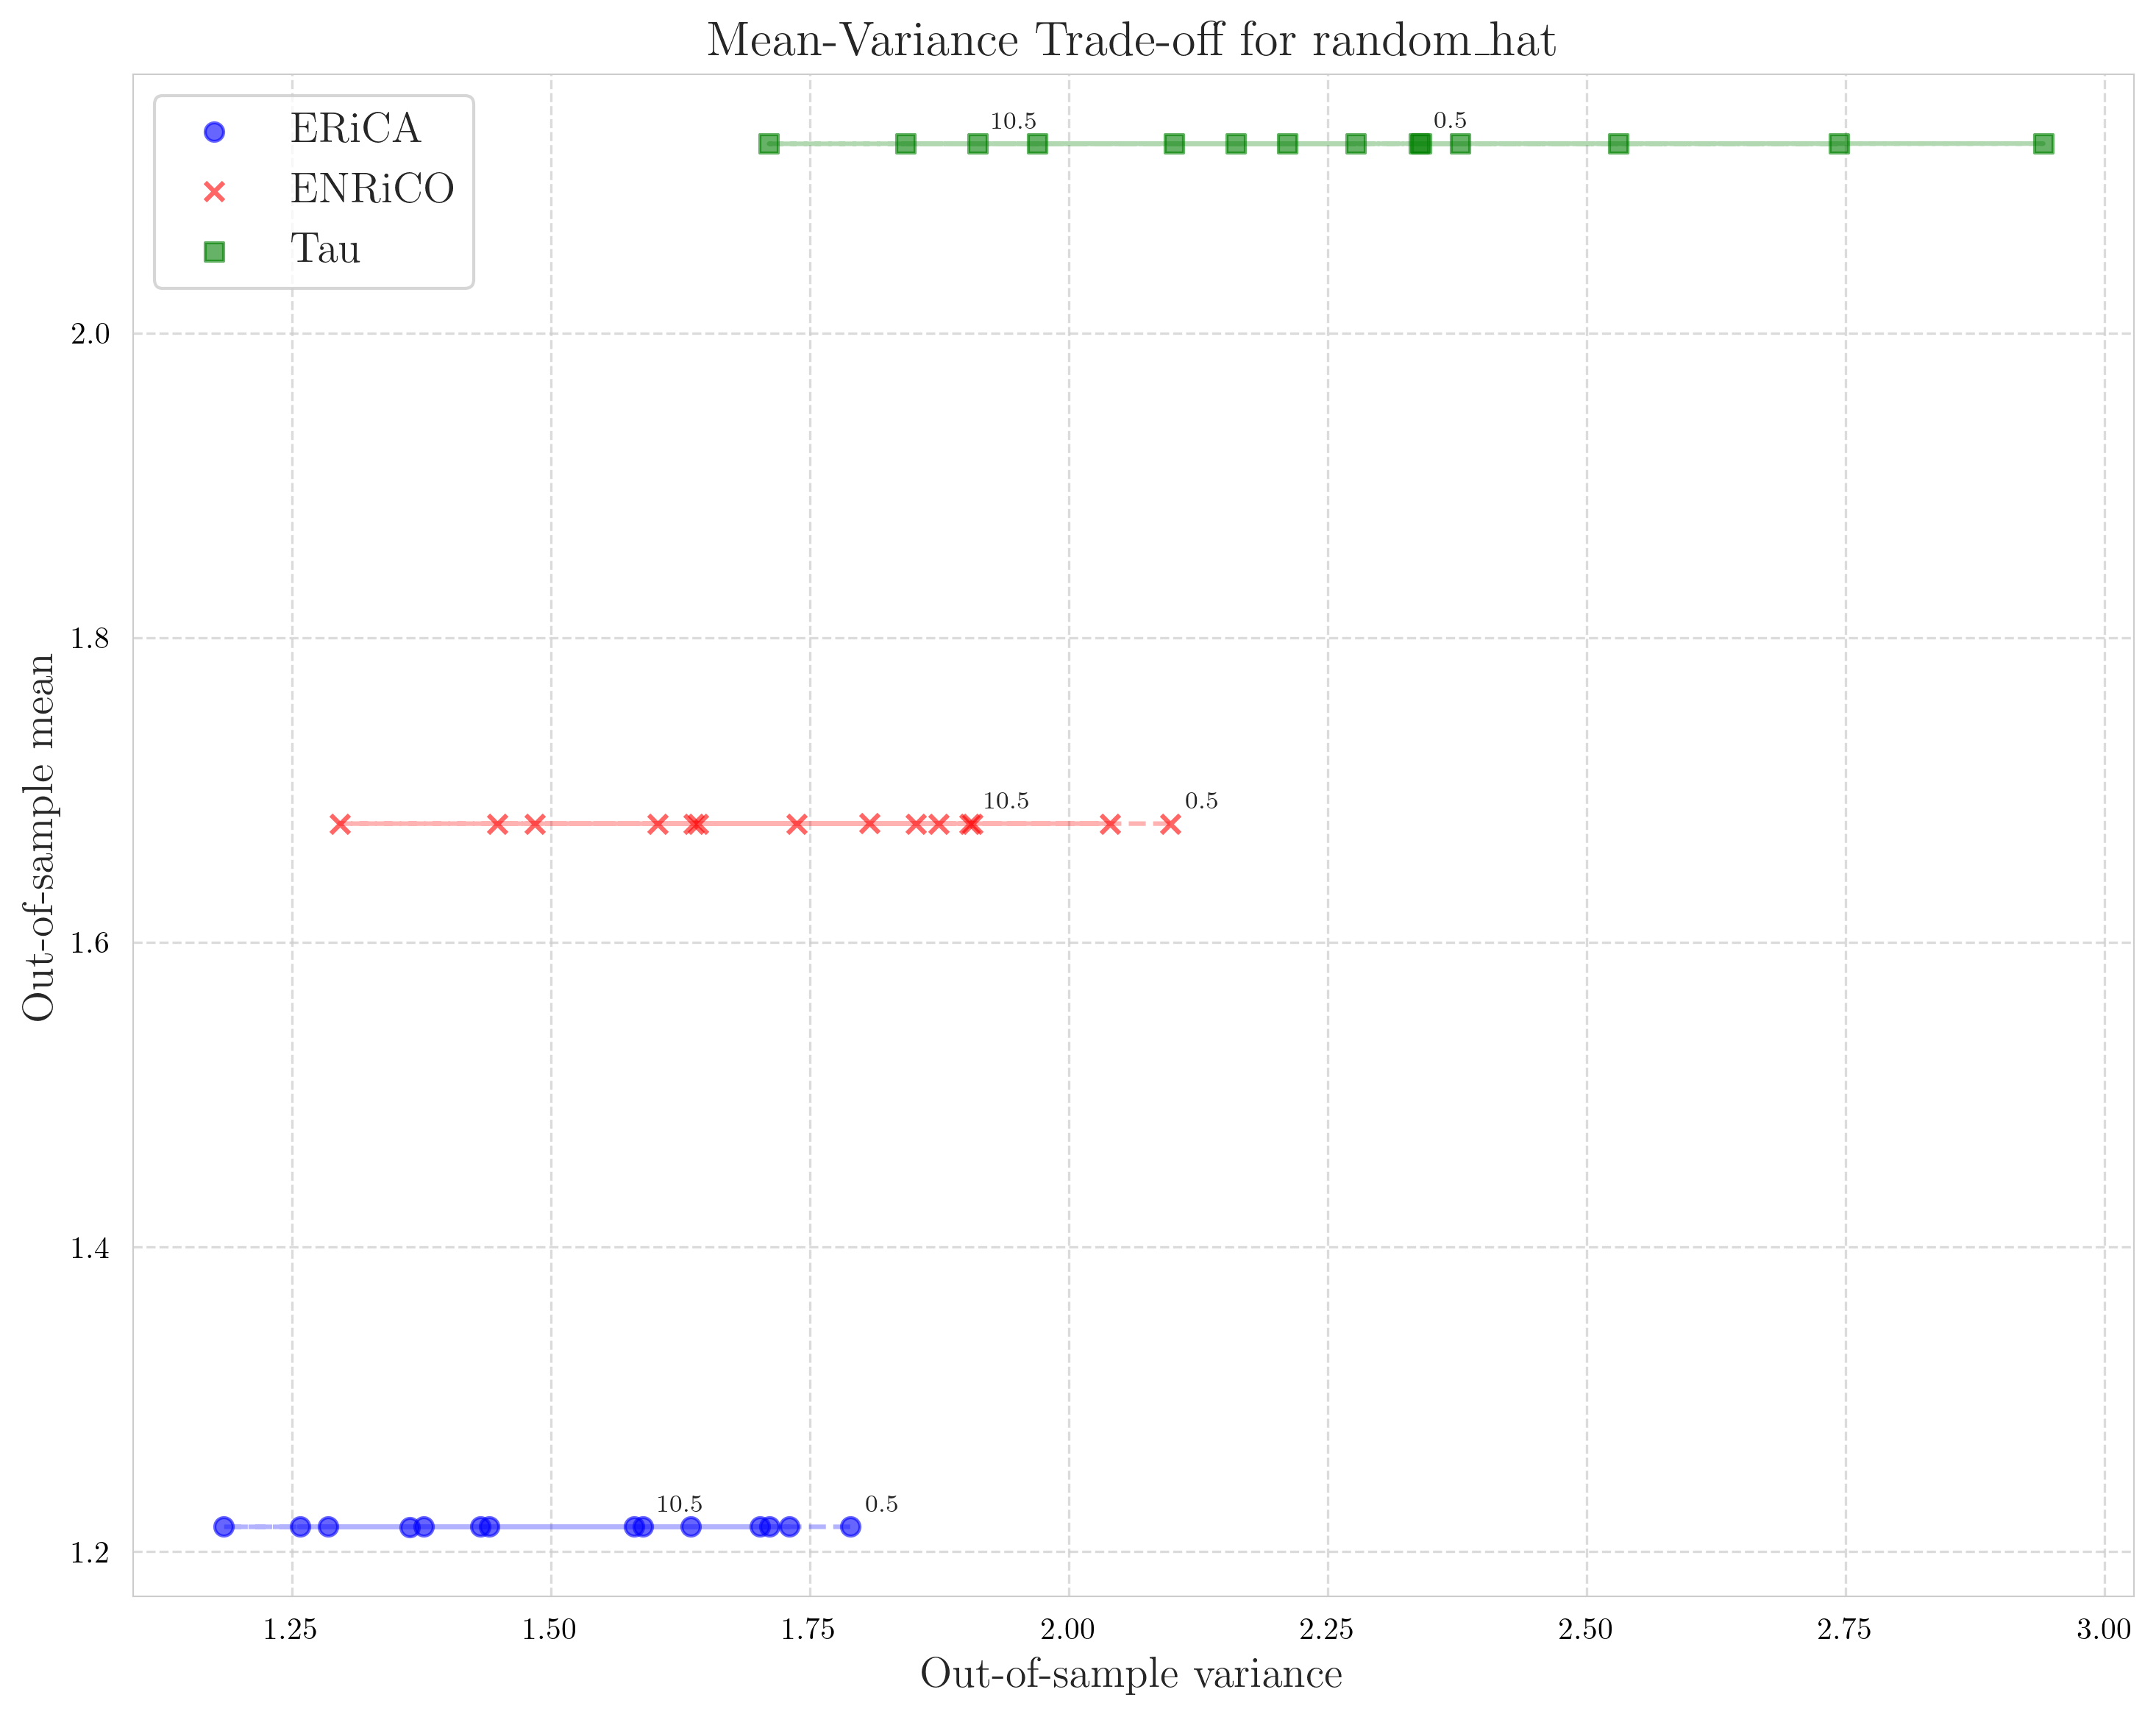

100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


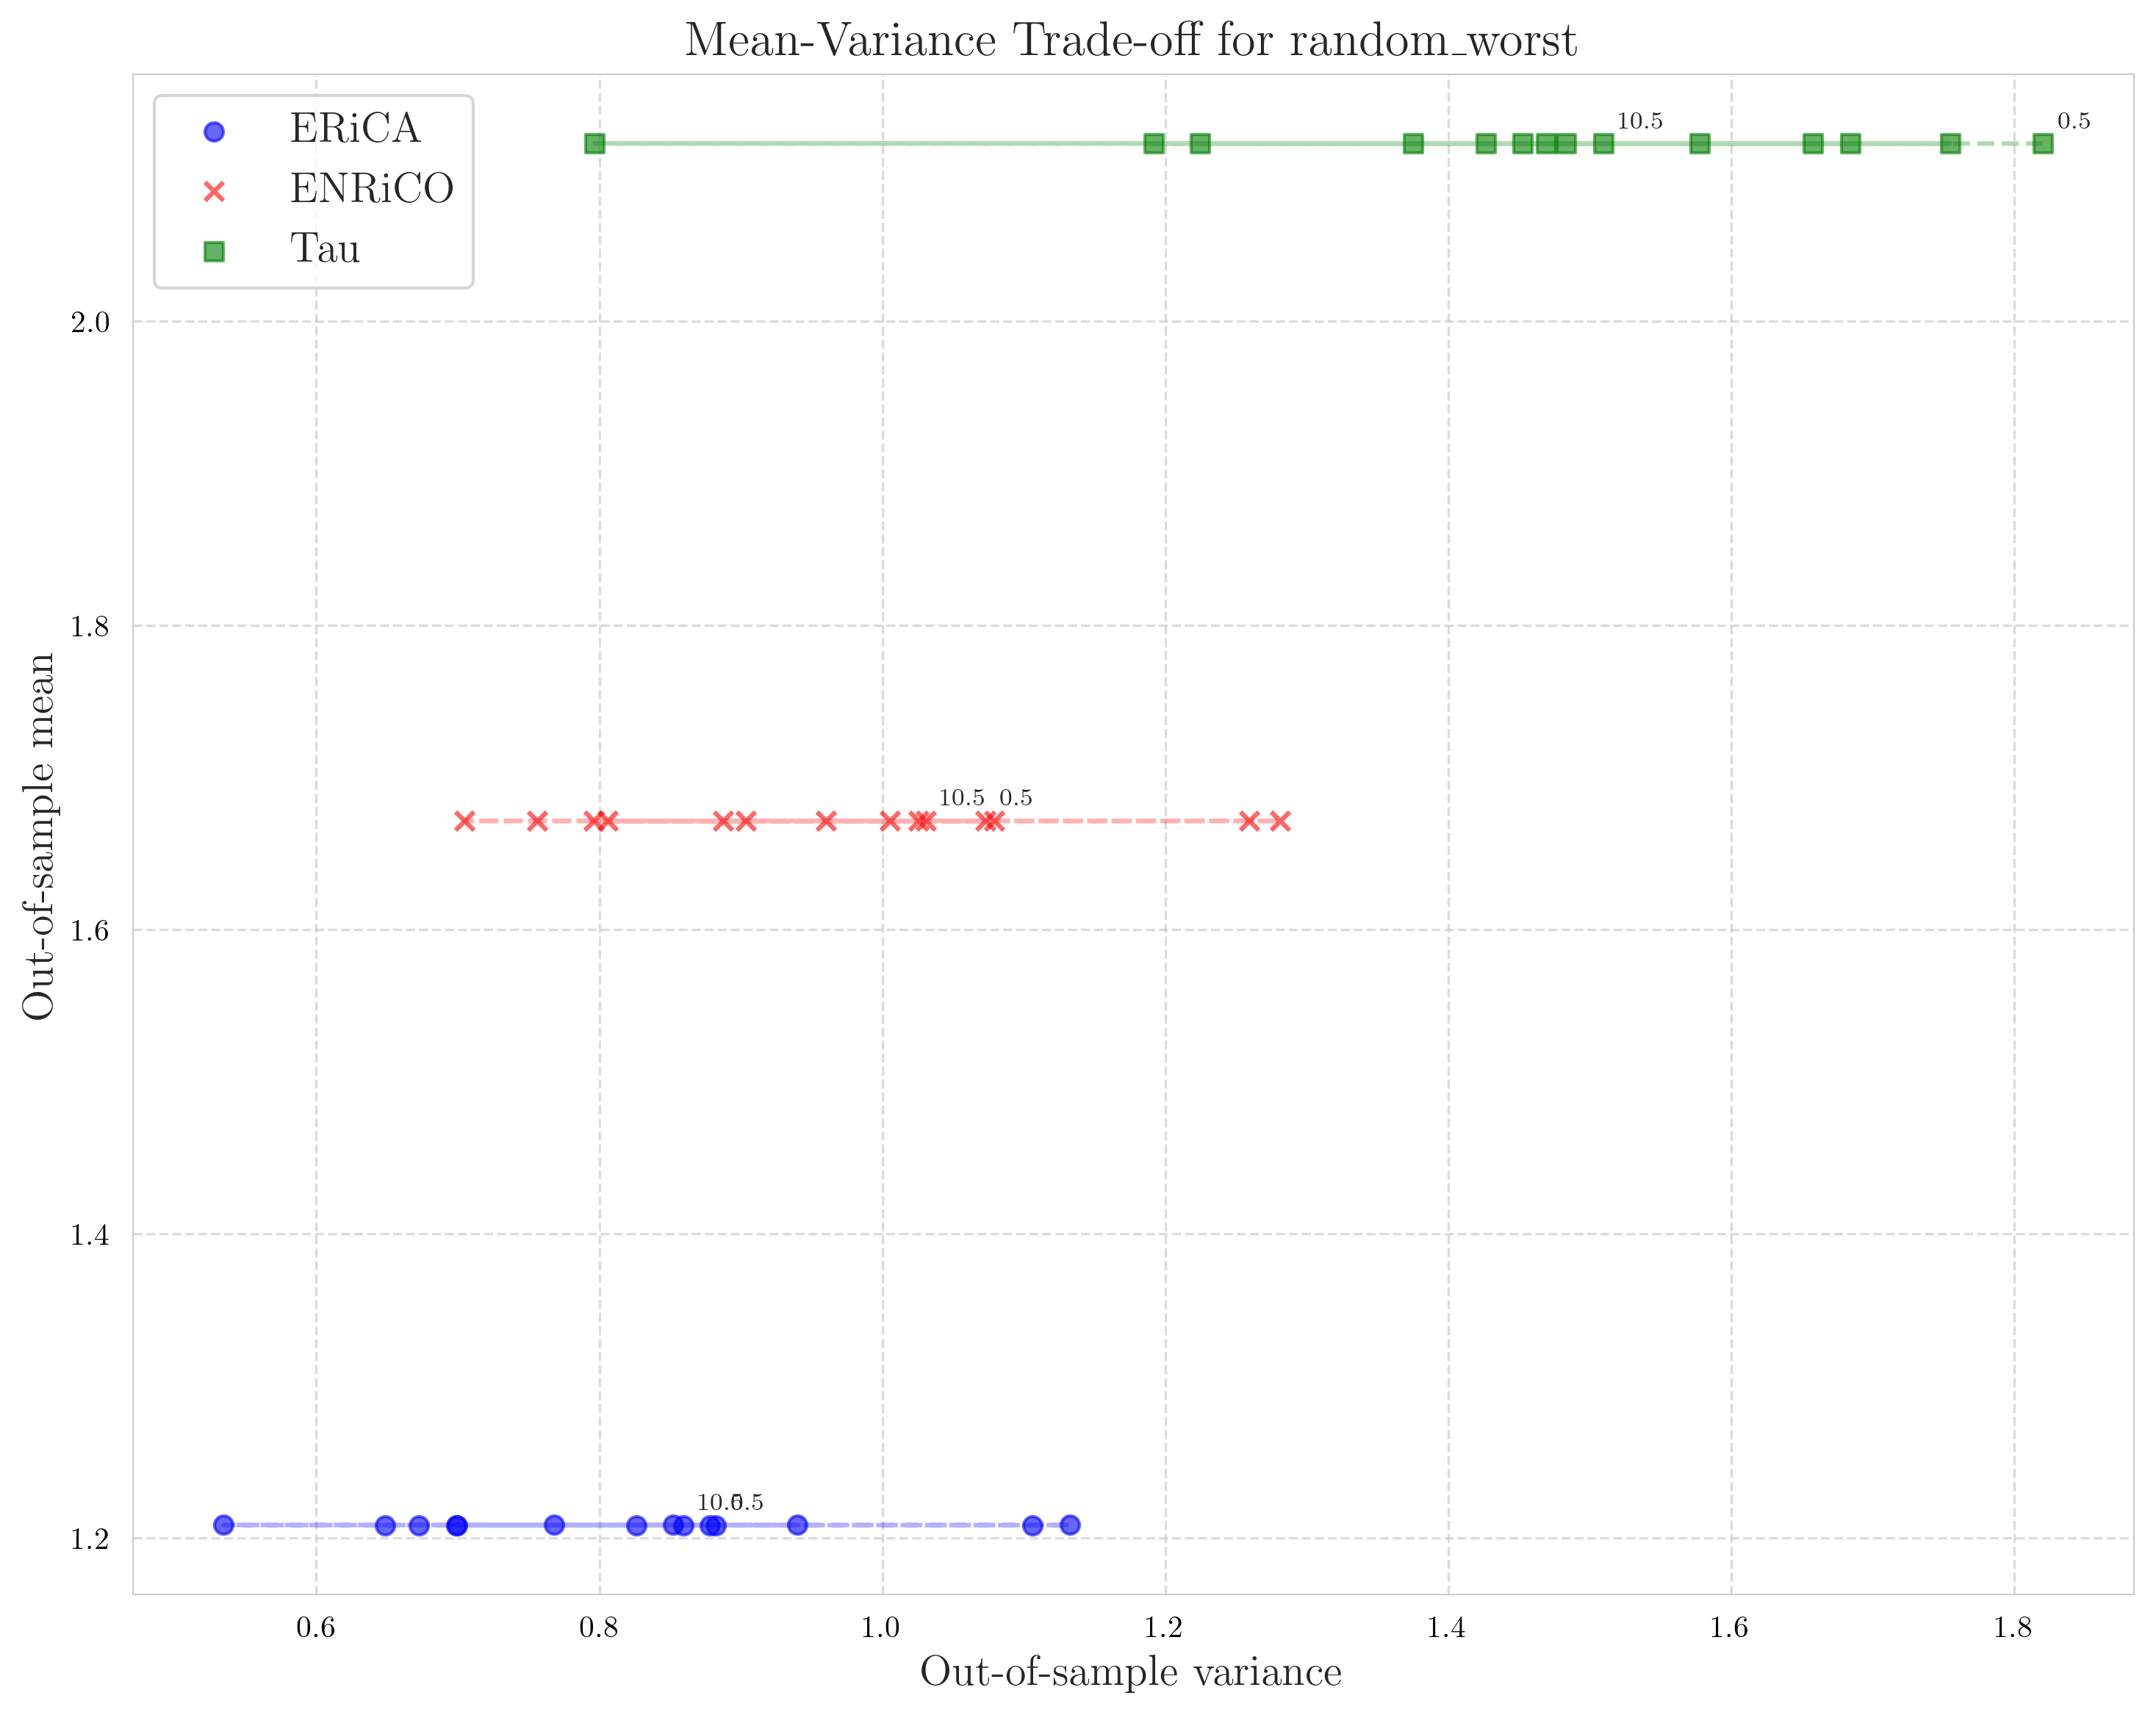

100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


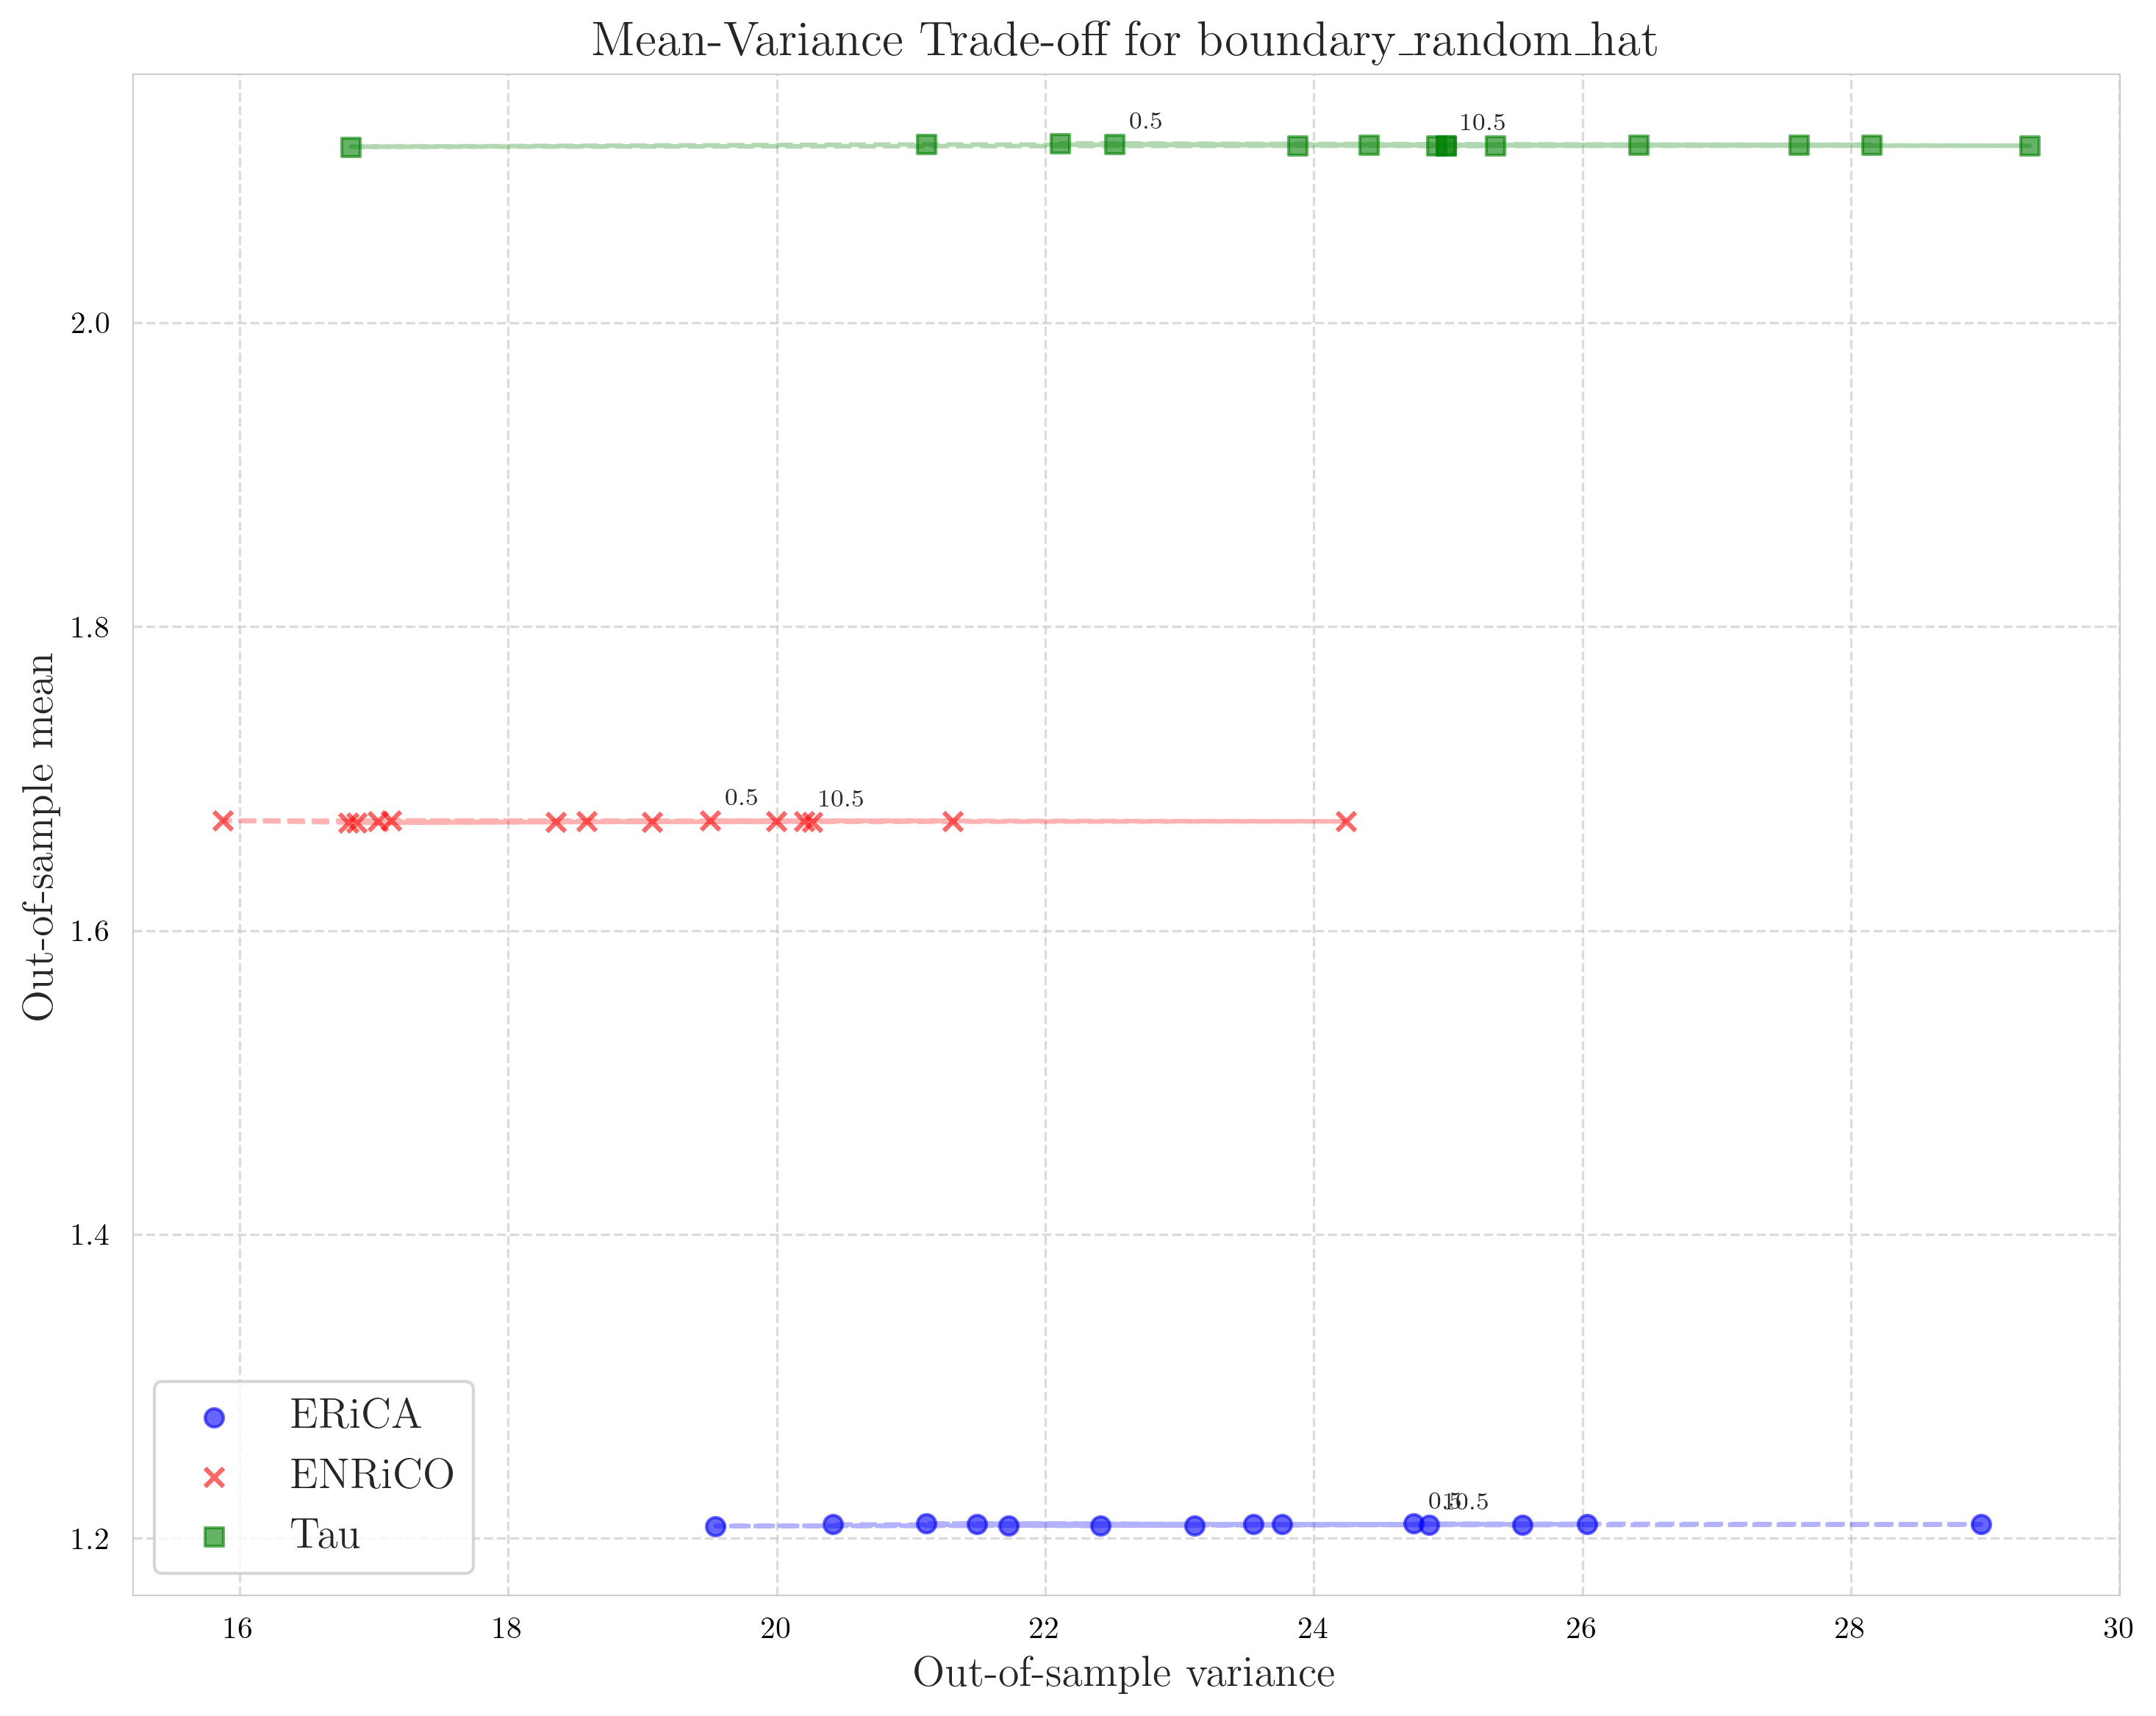

100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


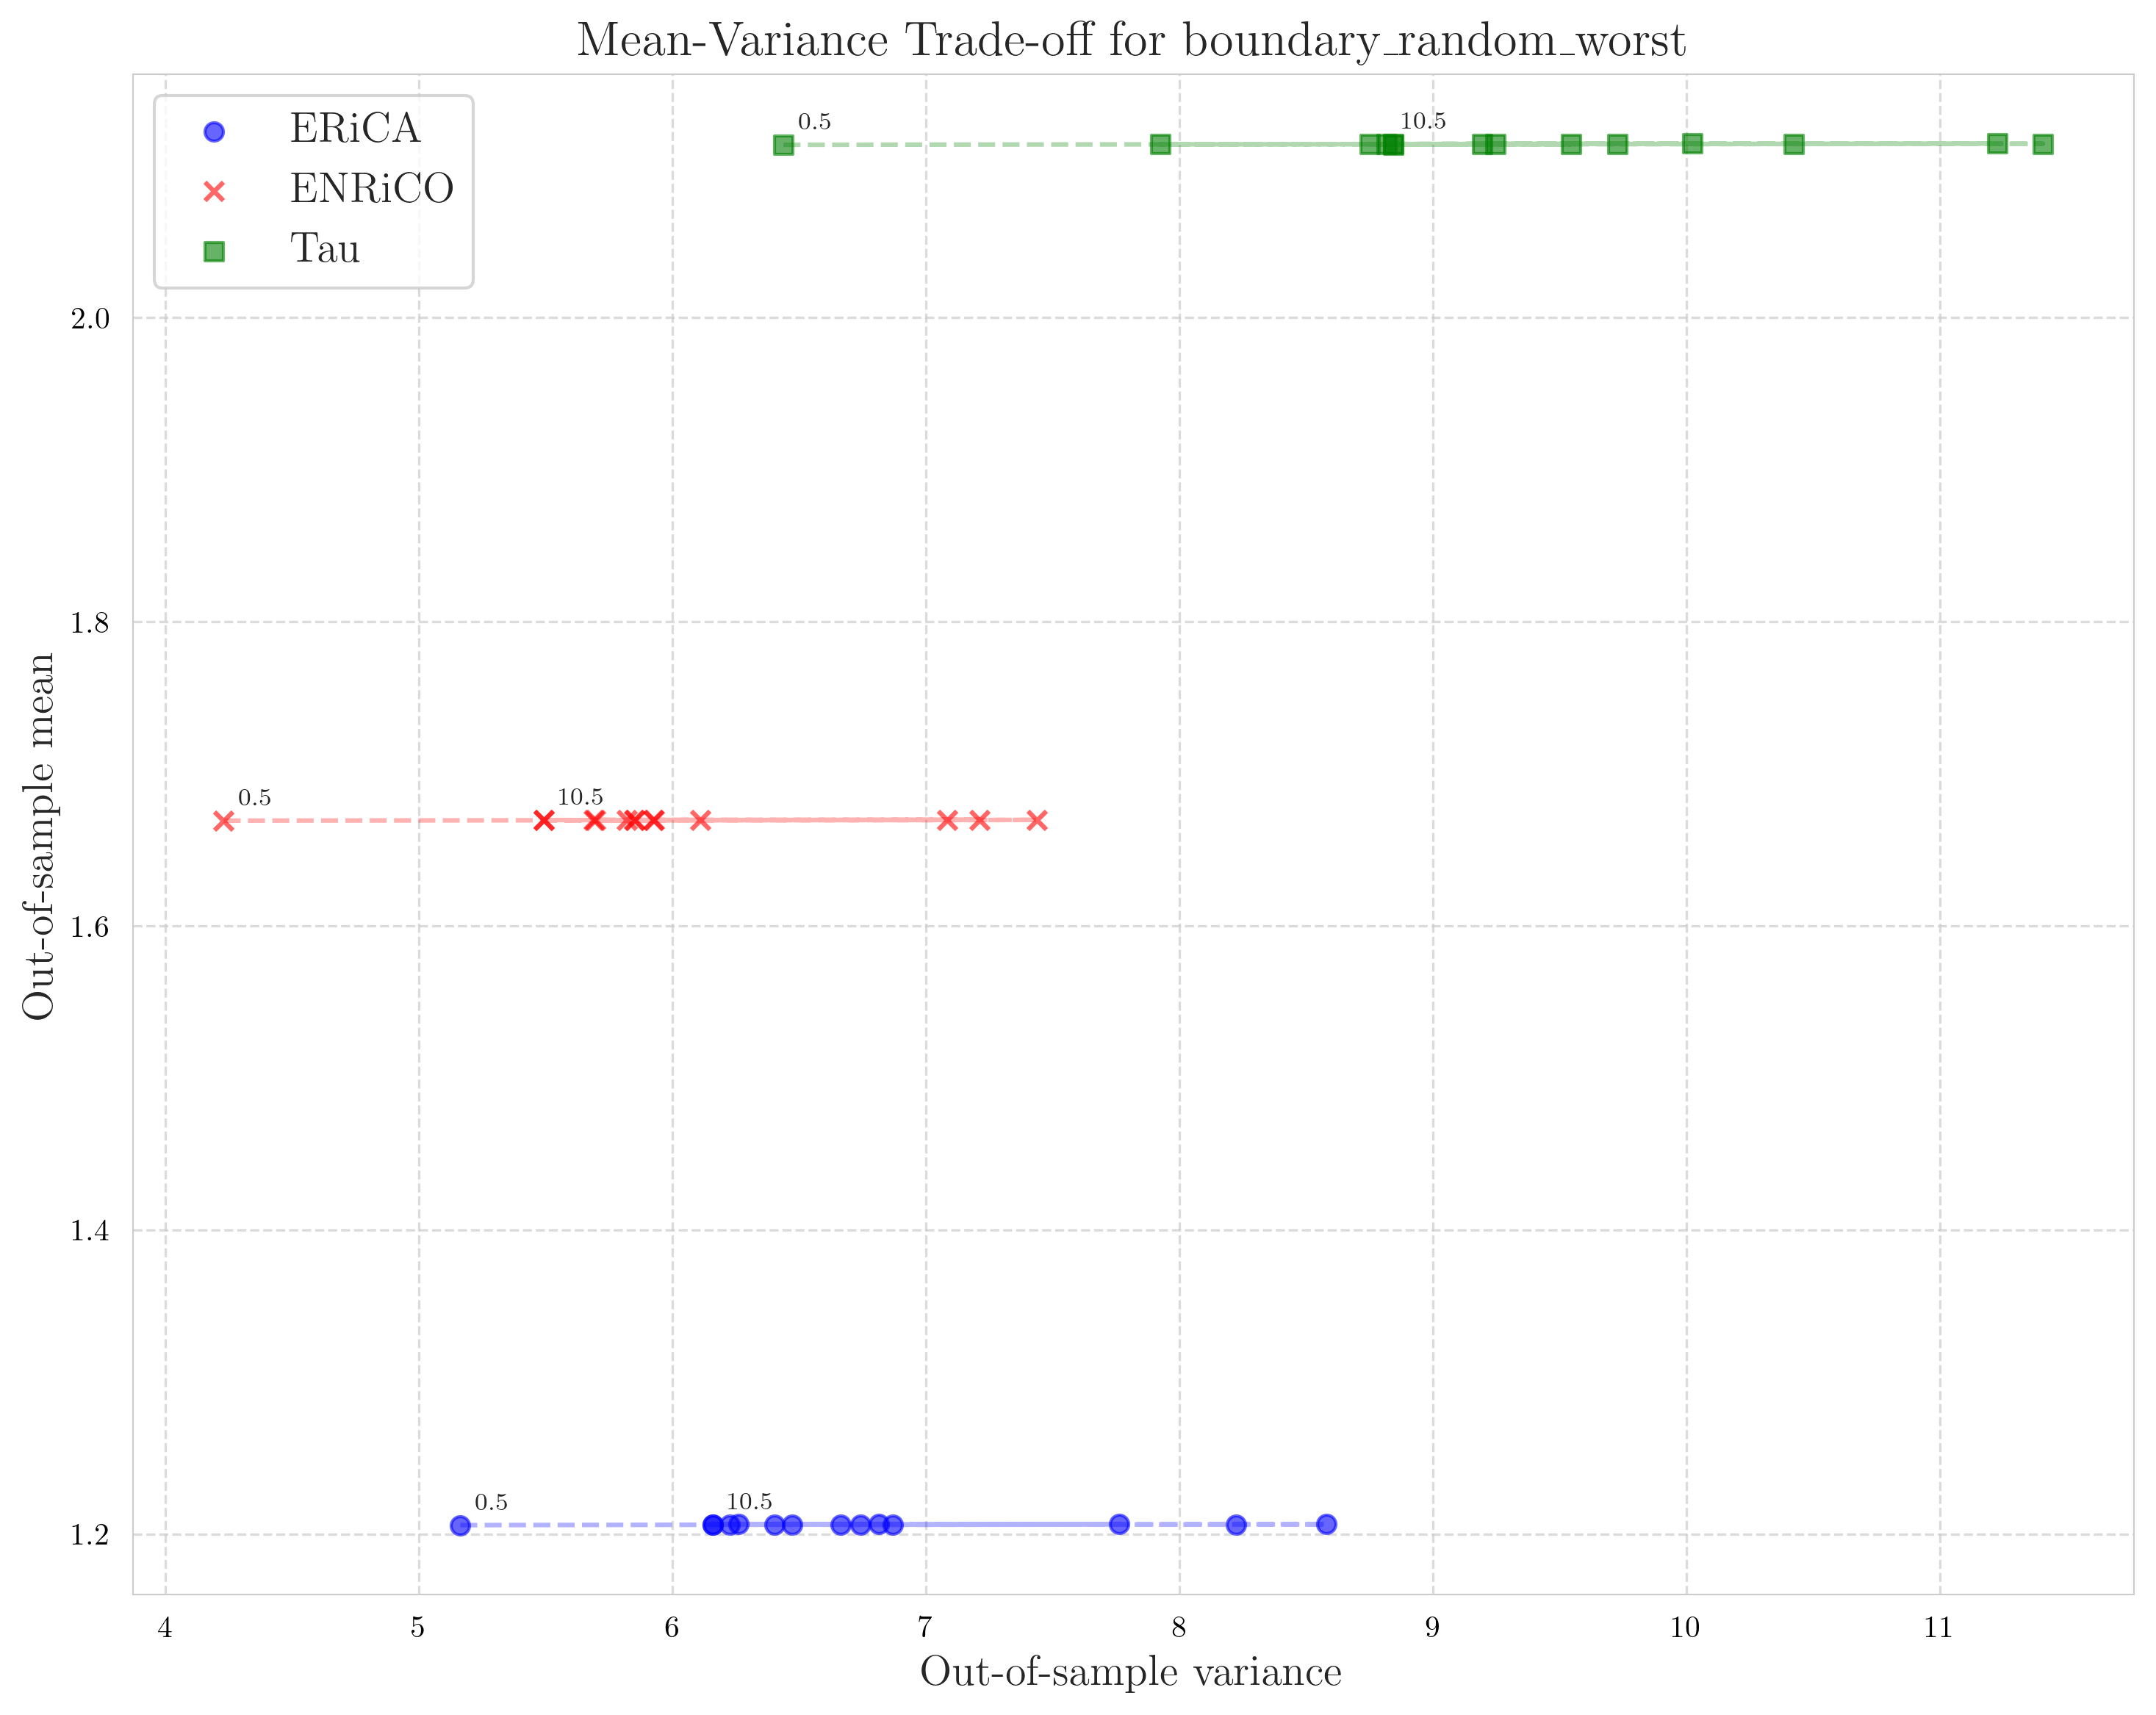

100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


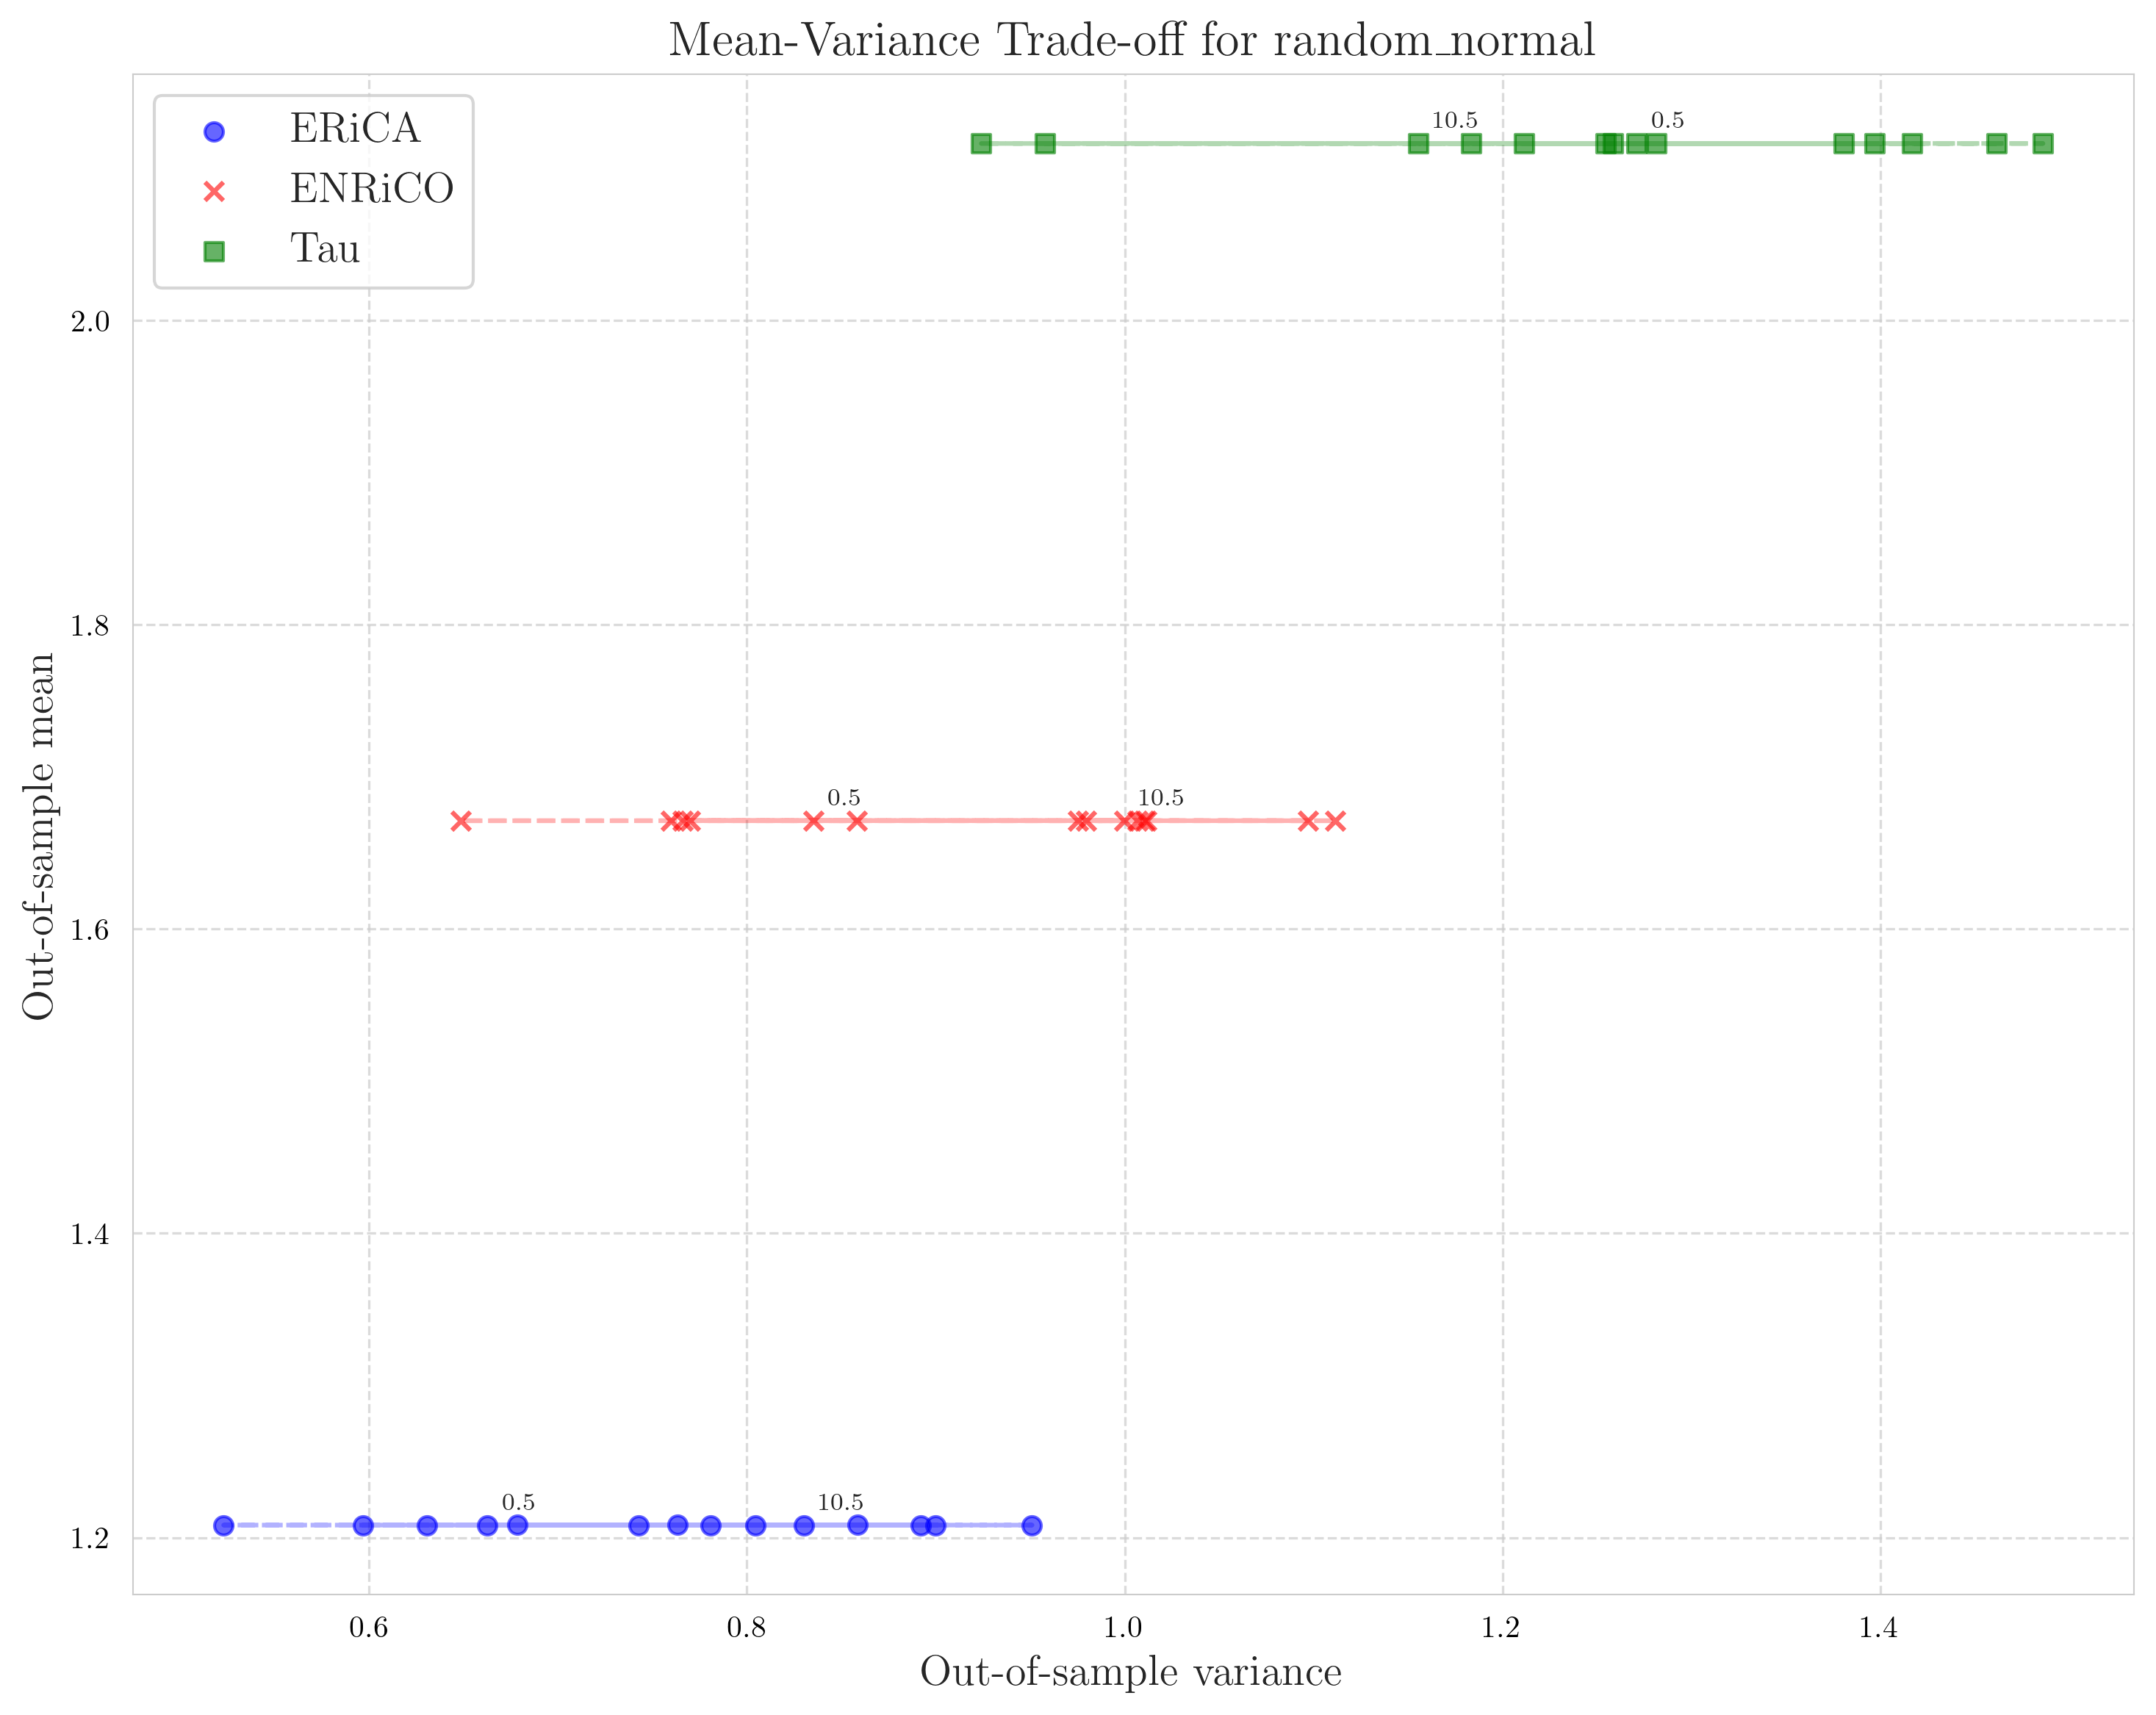

In [115]:
for pert in pert_types:
    pert_typeL = pert
    pert_typeH = pert
    radius_values = np.arange(.5, 14.5, 1).tolist()

    # Initialize dictionary to store results
    method_results = {
        'ERiCA': {'T': T_erica, 'means': [], 'variances': [], 'radius_labels': []},
        'ENRiCO': {'T': T_enrico, 'means': [], 'variances': [], 'radius_labels': []},
        'Tau': {'T': Tau, 'means': [], 'variances': [], 'radius_labels': []}
    }
    #method_results = {'ERiCA': {'T': T_erica, 'means': [], 'variances': [], 'radius_labels': []}}
    # Test each radius
    for radius in tqdm(radius_values):
        current_errors = {method: [] for method in method_results.keys()}
        
        for _ in range(num_iter):
            # Generate noise once per iteration
            pert_L = generate_pertubation(pert_typeL, 'L', experiment, rad=radius)
            pert_H = generate_pertubation(pert_typeH, 'H', experiment, rad=radius)

            for method_name, method_info in method_results.items():
                total = 0
                for iota in test_data.keys():
        
                    base, abst = test_data[iota]

                    if add_pertL:
                        base = base + pert_L 
                    if add_pertH:
                        abst = abst + pert_H 
                        
                    base_norm = base / np.linalg.norm(base, 'fro')
                    abst_norm = abst / np.linalg.norm(abst, 'fro')

                    tau_base = base @ method_info['T'].T
                    dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
                    total   += dist
            
                iter_avg = total / len(Ill)
                current_errors[method_name].append(iter_avg)
        
        # Store mean and variance for all methods
        for method_name in method_results:
            errors = current_errors[method_name]
            method_results[method_name]['means'].append(np.mean(errors)/10000)
            method_results[method_name]['variances'].append(np.std(errors))
            method_results[method_name]['radius_labels'].append(radius)

    # Create plot
    plt.figure(figsize=(10, 8))

    colors = {'ERiCA': 'blue', 'ENRiCO': 'red', 'Tau': 'green'}
    markers = {'ERiCA': 'o', 'ENRiCO': 'x', 'Tau': 's'}
    
    for method_name, method_info in method_results.items():
        means = method_info['means']
        variances = method_info['variances']
        radius_labels = method_info['radius_labels']
        
        # Create scatter plot with lines connecting points
        plt.plot(variances, means, 
                color=colors[method_name],
                linestyle='--',
                alpha=0.3)
        
        plt.scatter(variances, means,
                   color=colors[method_name],
                   marker=markers[method_name],
                   label=method_name,
                   alpha=0.6)
        
        # Add radius labels to selected points (e.g., every 20th point)
        for i in range(0, len(radius_labels), 10):
            plt.annotate(f'{radius_labels[i]:.1f}',
                        (variances[i], means[i]),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8)

    plt.xlabel('Out-of-sample variance')
    plt.ylabel('Out-of-sample mean')
    plt.title(f'Mean-Variance Trade-off for {pert}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [116]:
params_erica['']

{'L': {'pert_U': array([[-1.4362063 ,  0.36790392, -0.6661582 ],
         [ 0.45409942, -0.45787114,  1.1144302 ],
         [ 1.1614845 ,  0.68430686, -1.0327164 ],
         ...,
         [-0.07328907,  0.15869261, -0.7182101 ],
         [ 1.8846036 , -0.52673316,  1.7400004 ],
         [ 0.73480475, -0.0660063 ,  1.0404745 ]], dtype=float32),
  'radius_worst': 1.8759864800748938,
  'pert_hat': tensor([[ 1.0514, -1.9269,  0.2506],
          [ 1.2814, -0.3493,  0.5575],
          [ 1.1150, -1.9952,  1.6094],
          ...,
          [ 1.4841, -2.8457,  0.5806],
          [ 1.0538, -2.5250,  0.3807],
          [ 0.6024, -0.8448,  0.5519]]),
  'radius': 3},
 'H': {'pert_U': array([[-0.9424482 , -1.38652   ],
         [ 0.38262   ,  1.323944  ],
         [ 1.7266499 ,  0.38255212],
         ...,
         [ 0.46256152,  0.3340331 ],
         [ 1.0918287 ,  0.2849734 ],
         [ 0.10302369,  0.5857212 ]], dtype=float32),
  'radius_worst': 1.463439334237798,
  'pert_hat': tensor([[ 2.7576, 

In [117]:
def compute_empirical_worst_case_distance(params_worst):
    pert_worst = params_worst['pert_U']
    N          = pert_worst.shape[0]

    return (1/np.sqrt(N)) * np.linalg.norm(pert_worst, 'fro') #torch.norm(pert_worst, p='fro') maybe torch different output

Radius: 2


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


For L (epsilon): frobenius norm: 1.8759864800748938, radius_squared: 4, constraint satisfied: True
For H (delta): frobenius: 1.463439334237798, radius_squared: 4, constraint satisfied: True


100%|██████████| 664/664 [05:52<00:00,  1.89it/s]


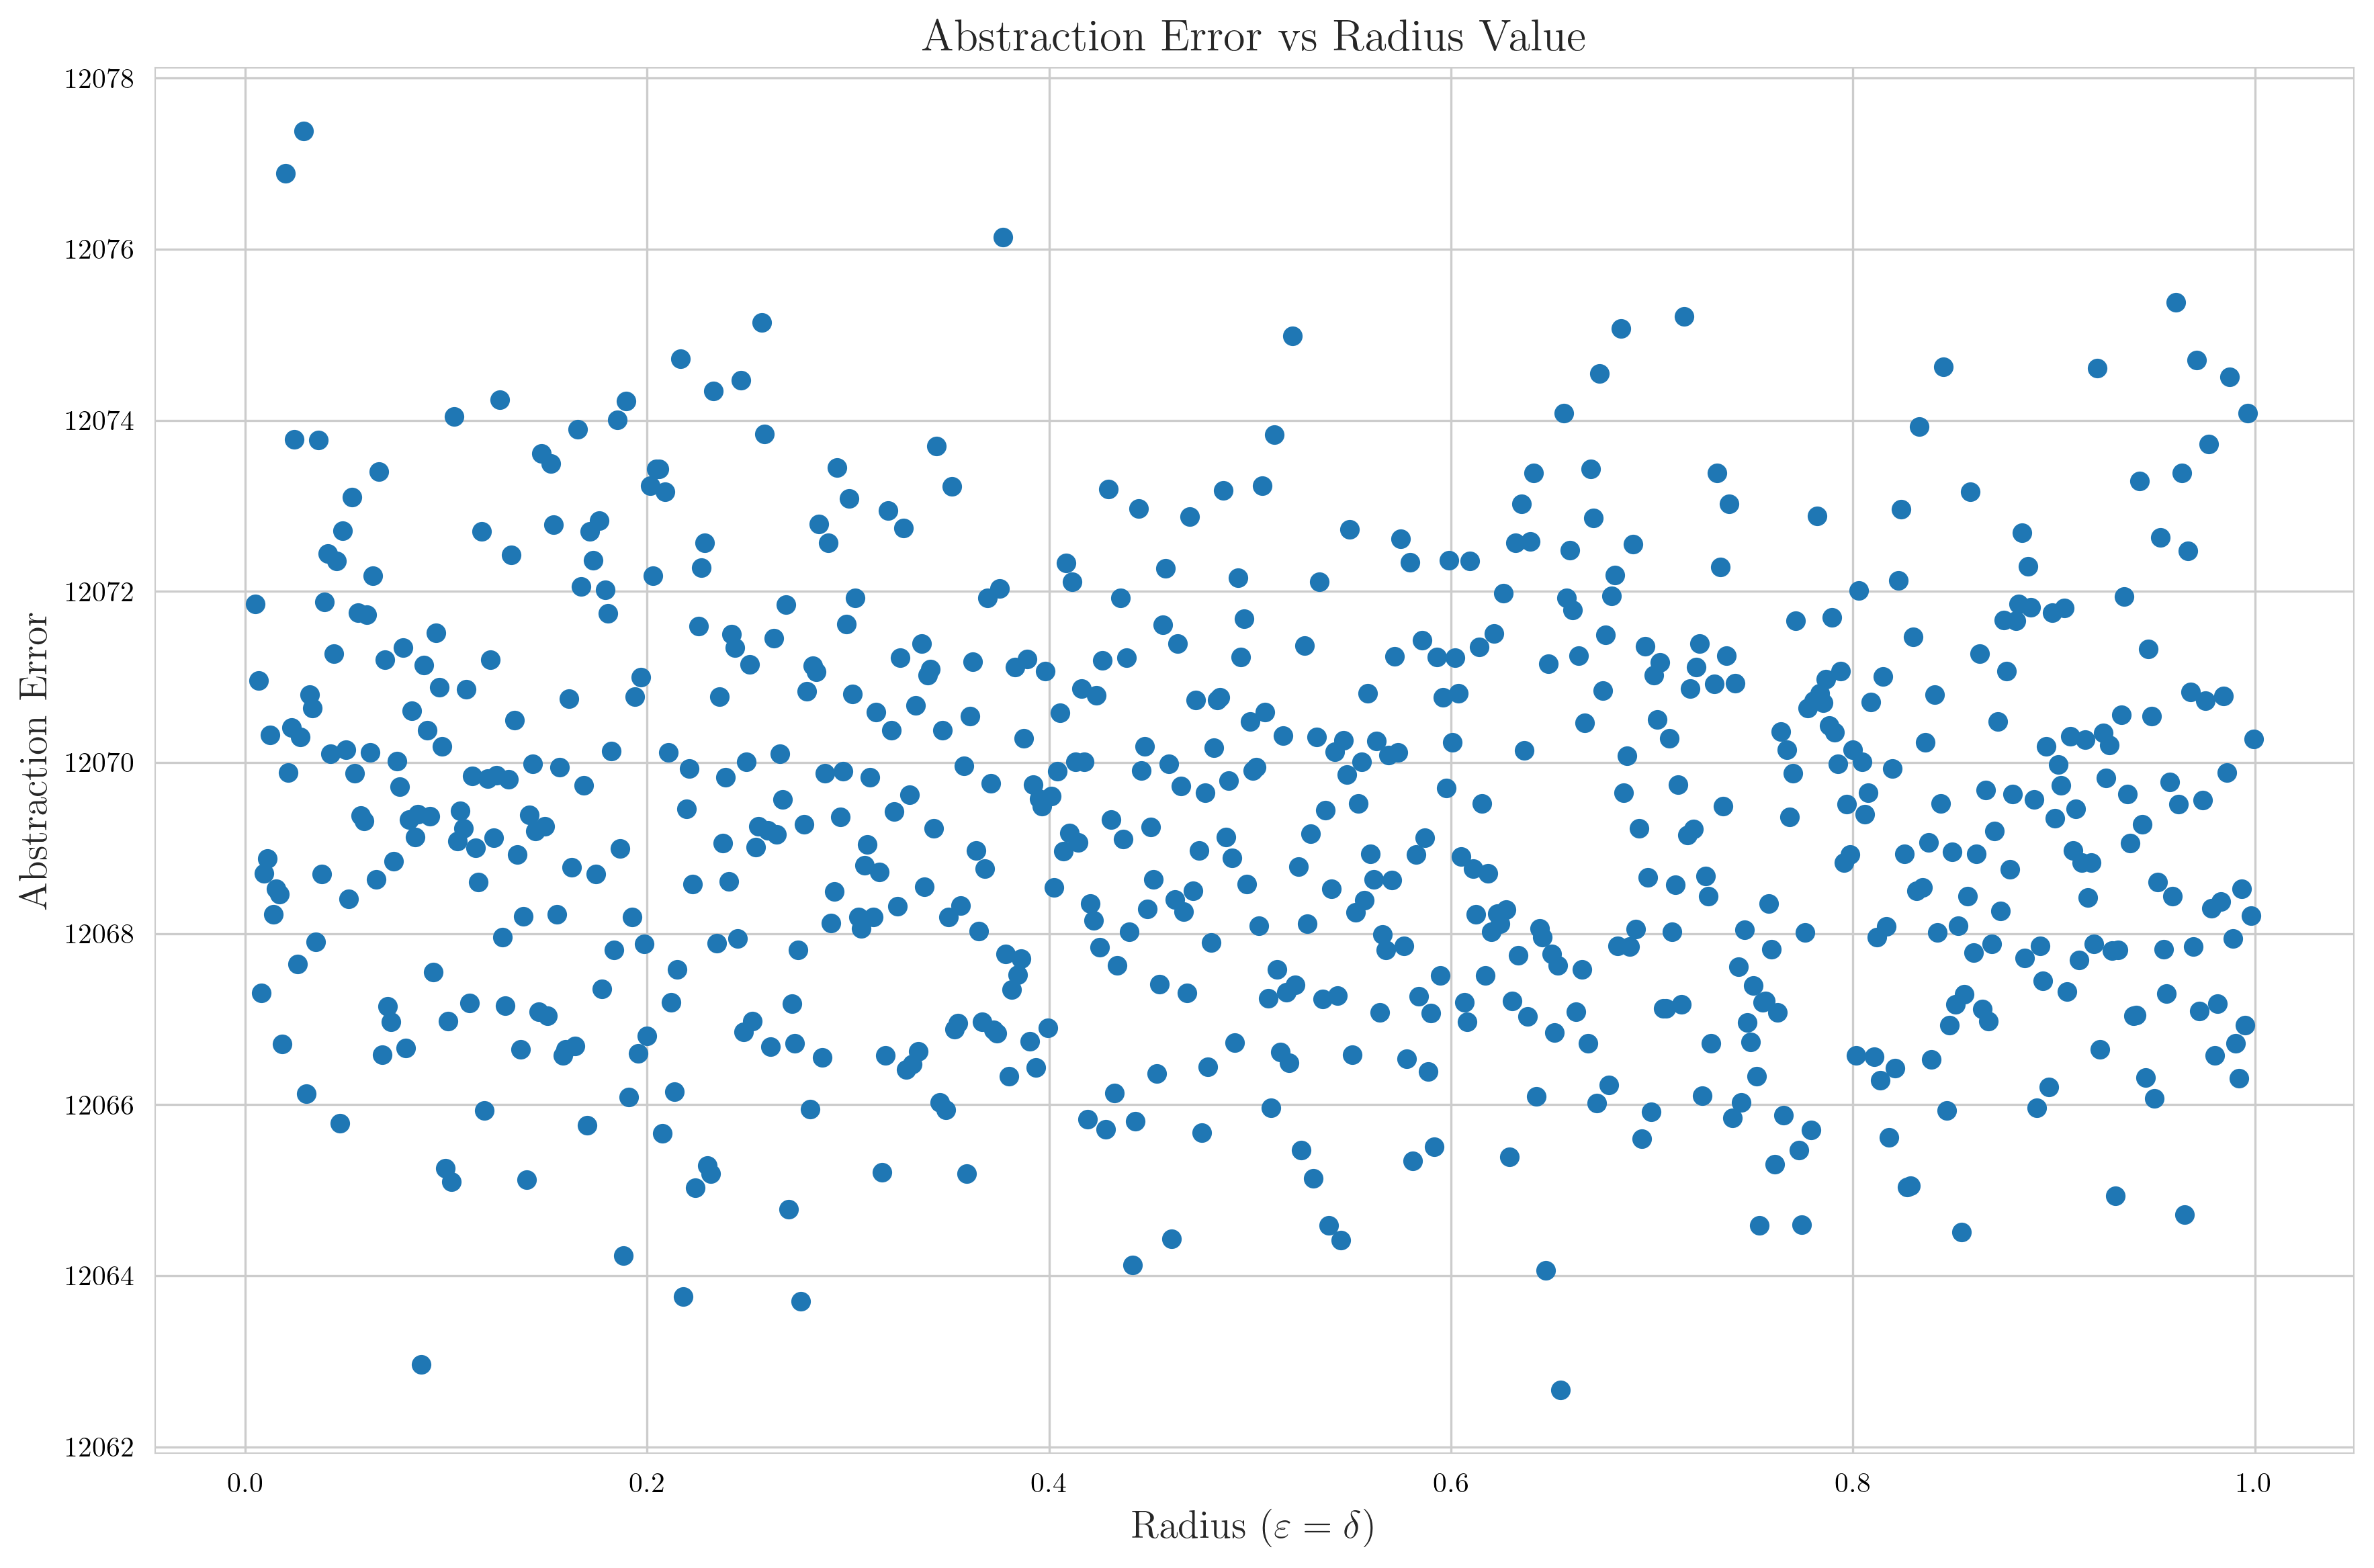


Best radius value:
Radius (ε=δ): 0.6545000000000002
Mean error: 12062.6614 ± 19.1836

Radius: 3


100%|██████████| 50/50 [00:08<00:00,  6.13it/s]


For L (epsilon): frobenius norm: 1.8759864800748938, radius_squared: 9, constraint satisfied: True
For H (delta): frobenius: 1.463439334237798, radius_squared: 9, constraint satisfied: True


100%|██████████| 664/664 [05:50<00:00,  1.89it/s]


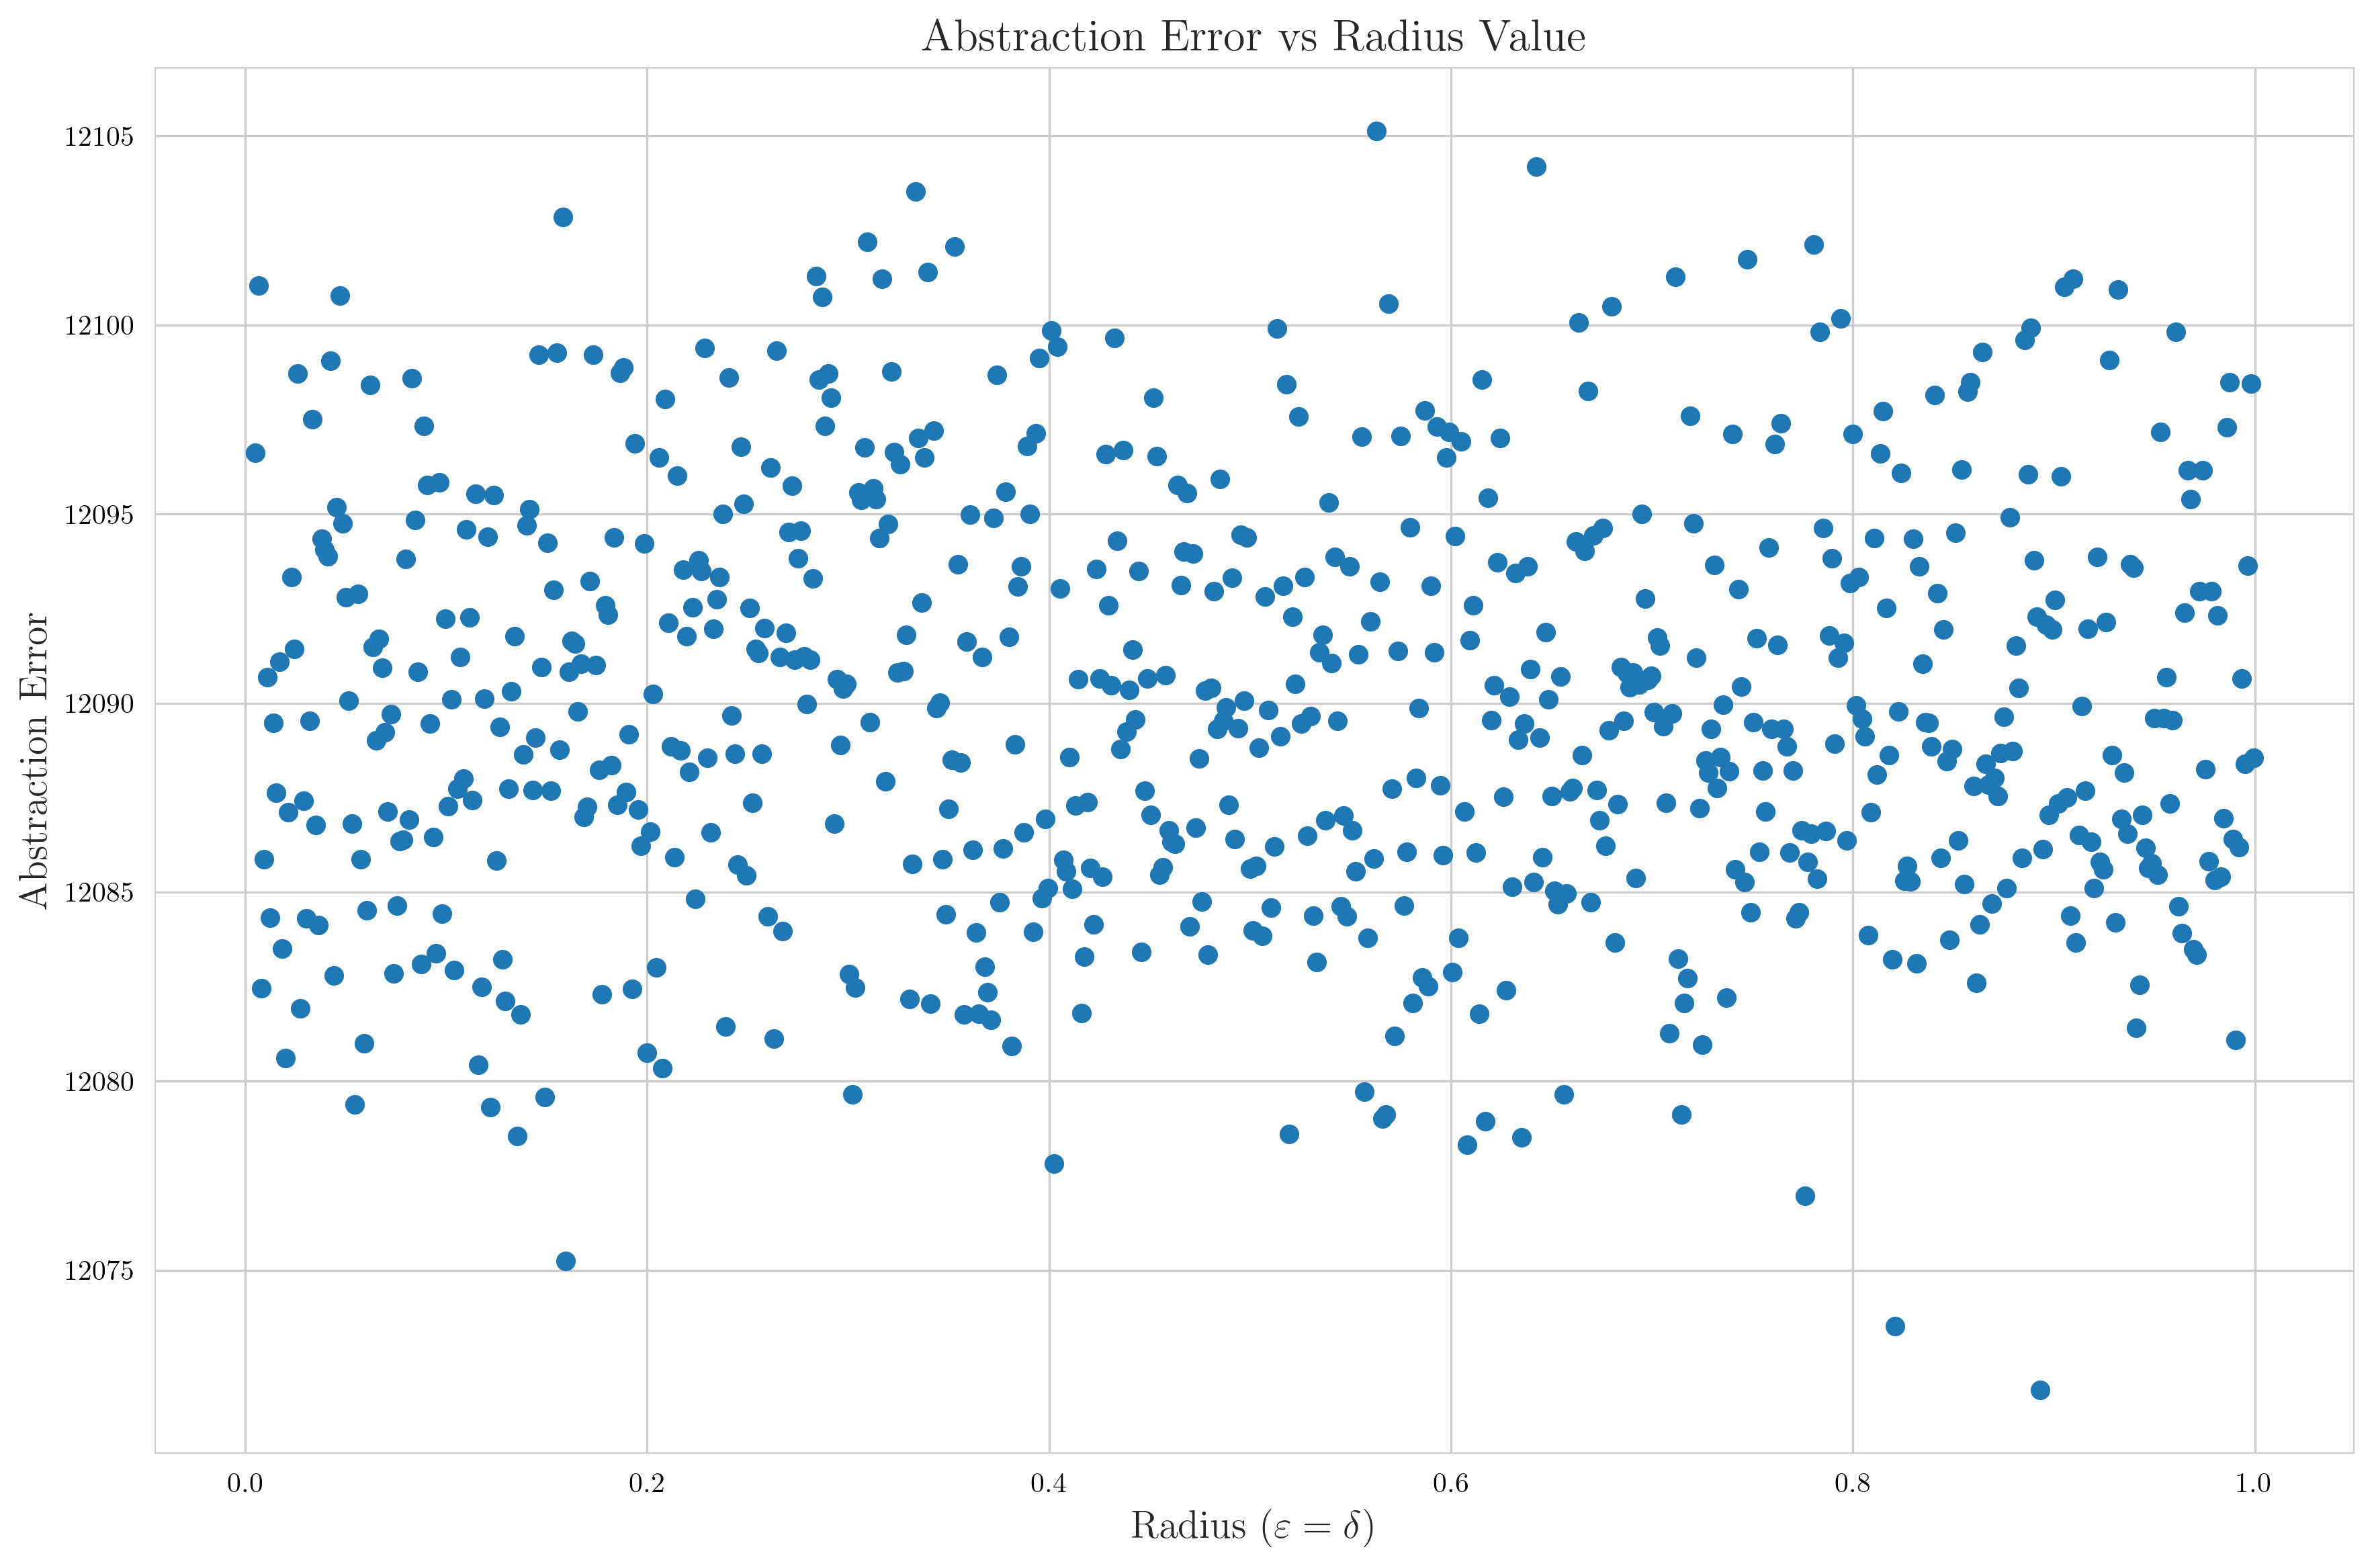


Best radius value:
Radius (ε=δ): 0.8930000000000002
Mean error: 12071.8256 ± 31.9801

Radius: 8


100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


For L (epsilon): frobenius norm: 1.8759864800748938, radius_squared: 64, constraint satisfied: True
For H (delta): frobenius: 1.463439334237798, radius_squared: 64, constraint satisfied: True


100%|██████████| 664/664 [05:58<00:00,  1.85it/s]


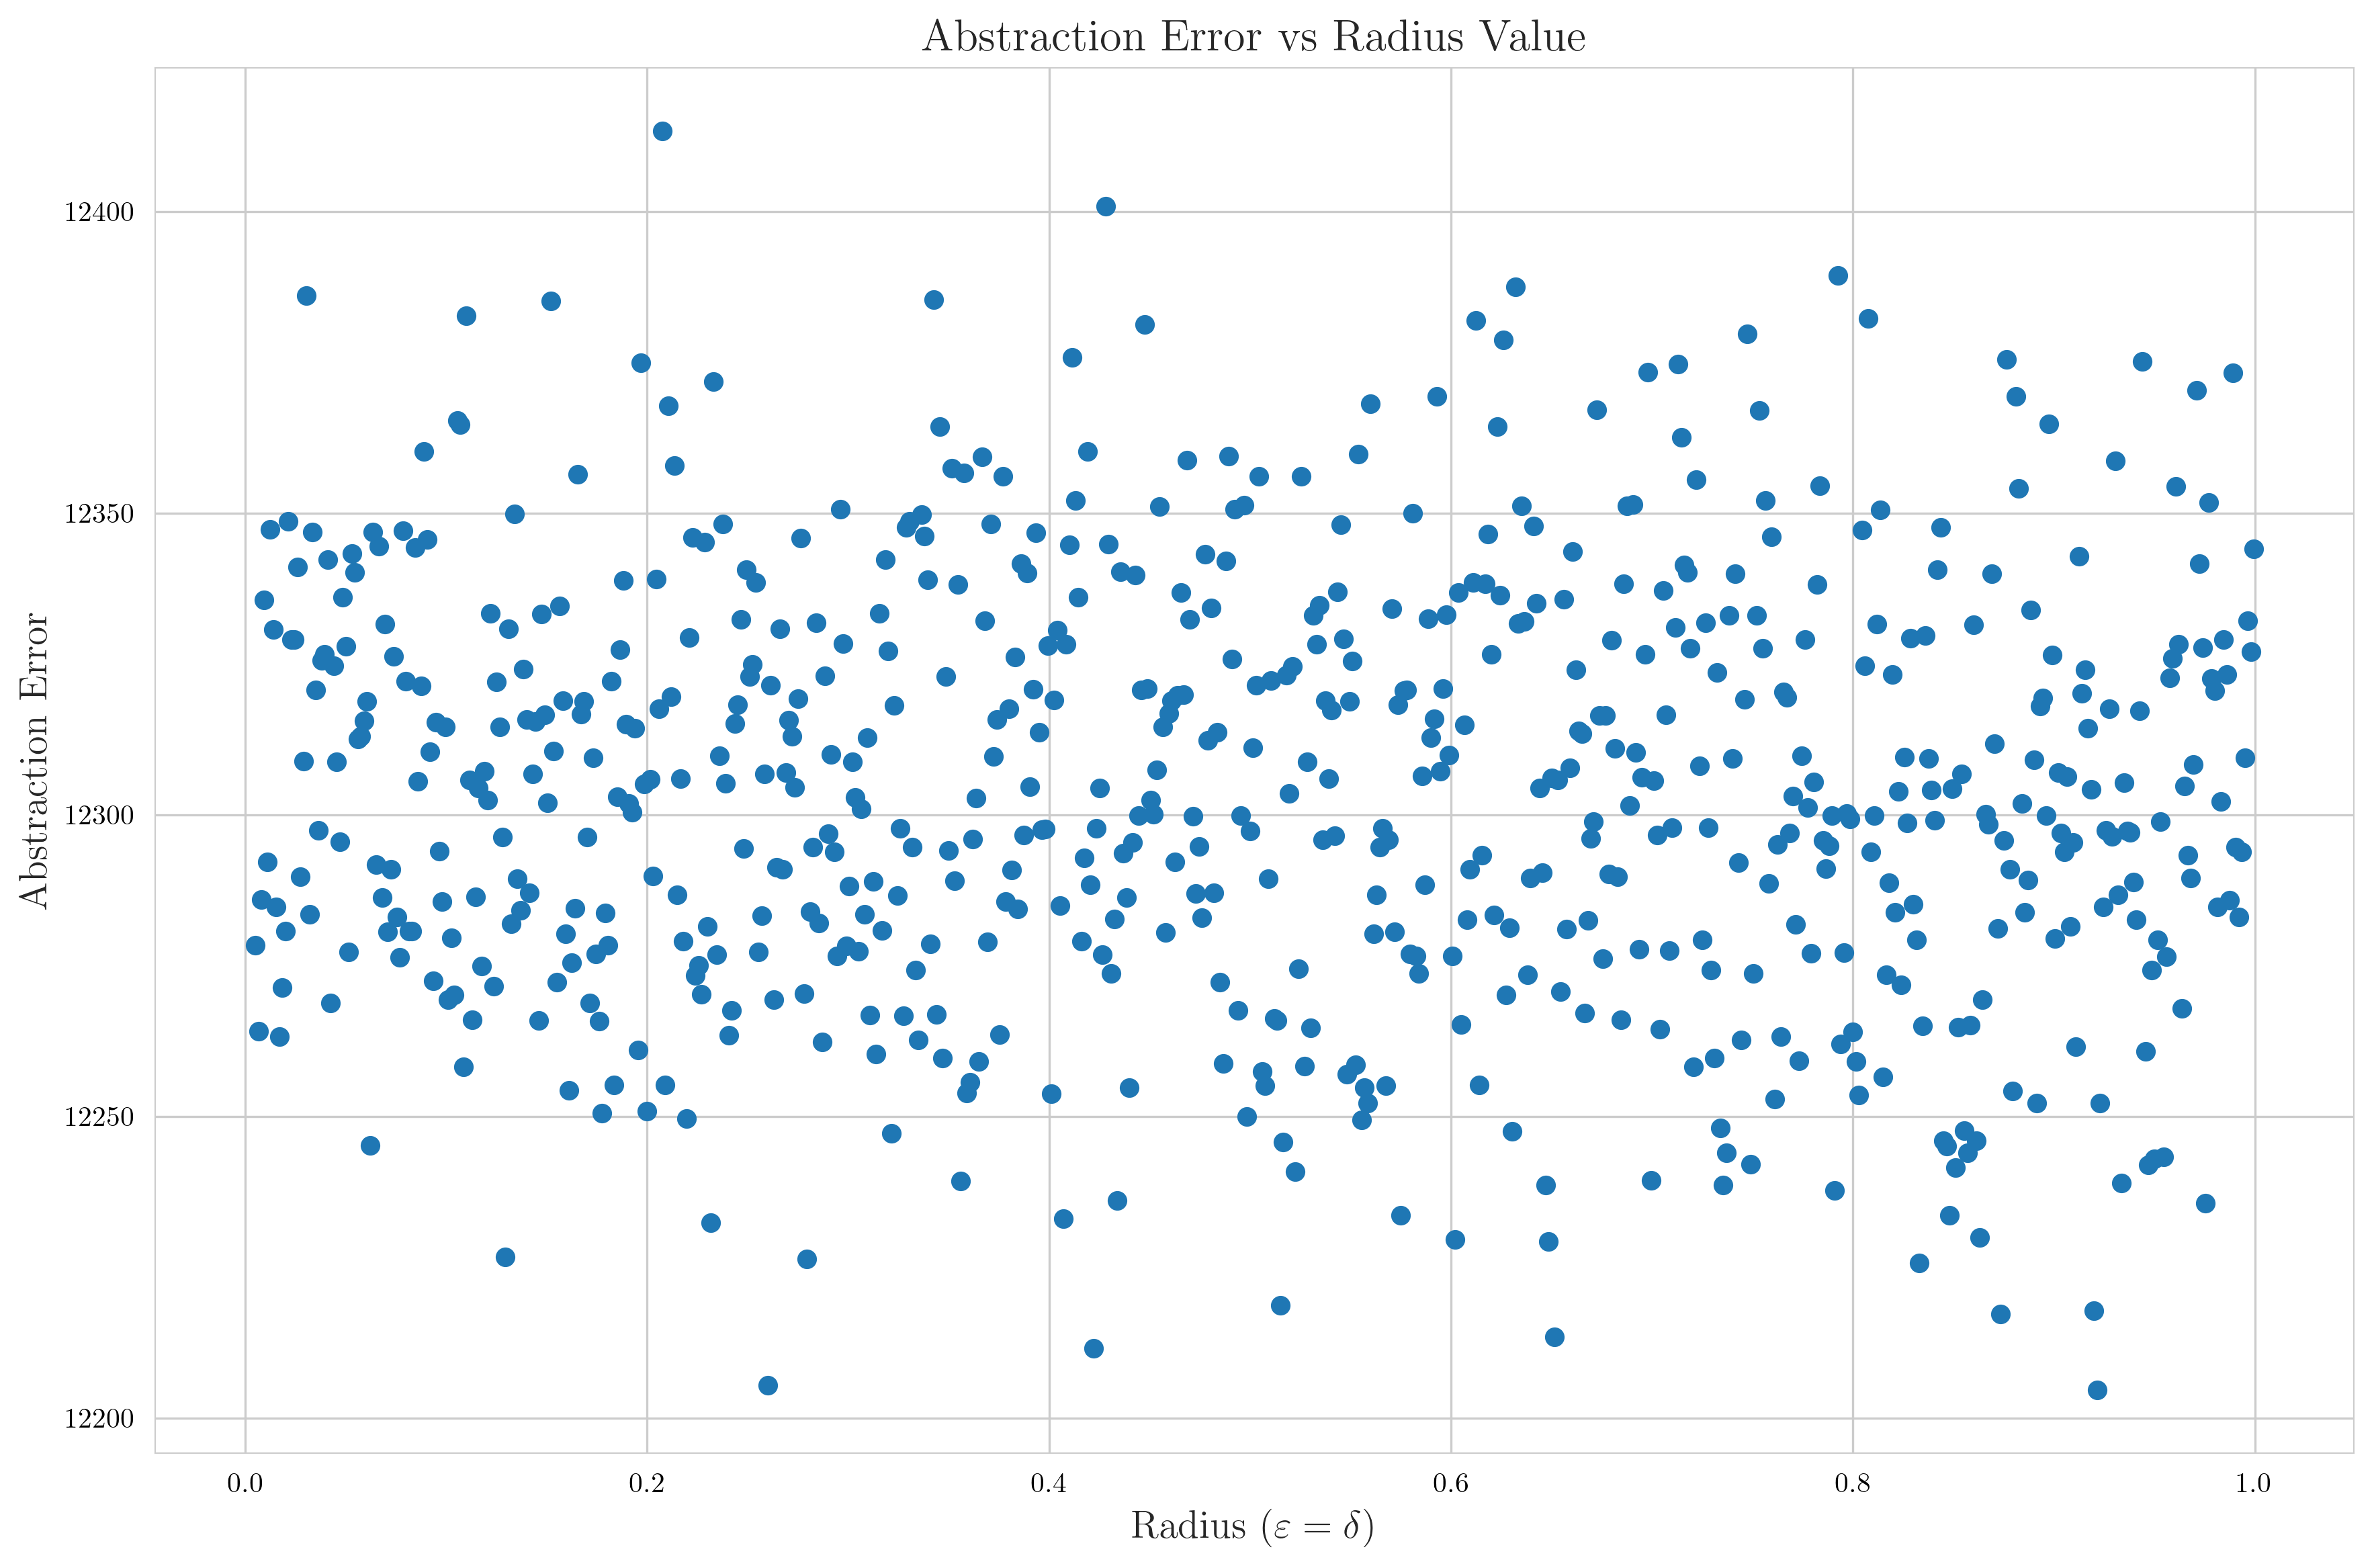


Best radius value:
Radius (ε=δ): 0.9215000000000003
Mean error: 12204.6214 ± 227.1587

Radius: 12


100%|██████████| 50/50 [00:07<00:00,  6.62it/s]


For L (epsilon): frobenius norm: 1.8759864800748938, radius_squared: 144, constraint satisfied: True
For H (delta): frobenius: 1.463439334237798, radius_squared: 144, constraint satisfied: True


100%|██████████| 664/664 [06:18<00:00,  1.75it/s]


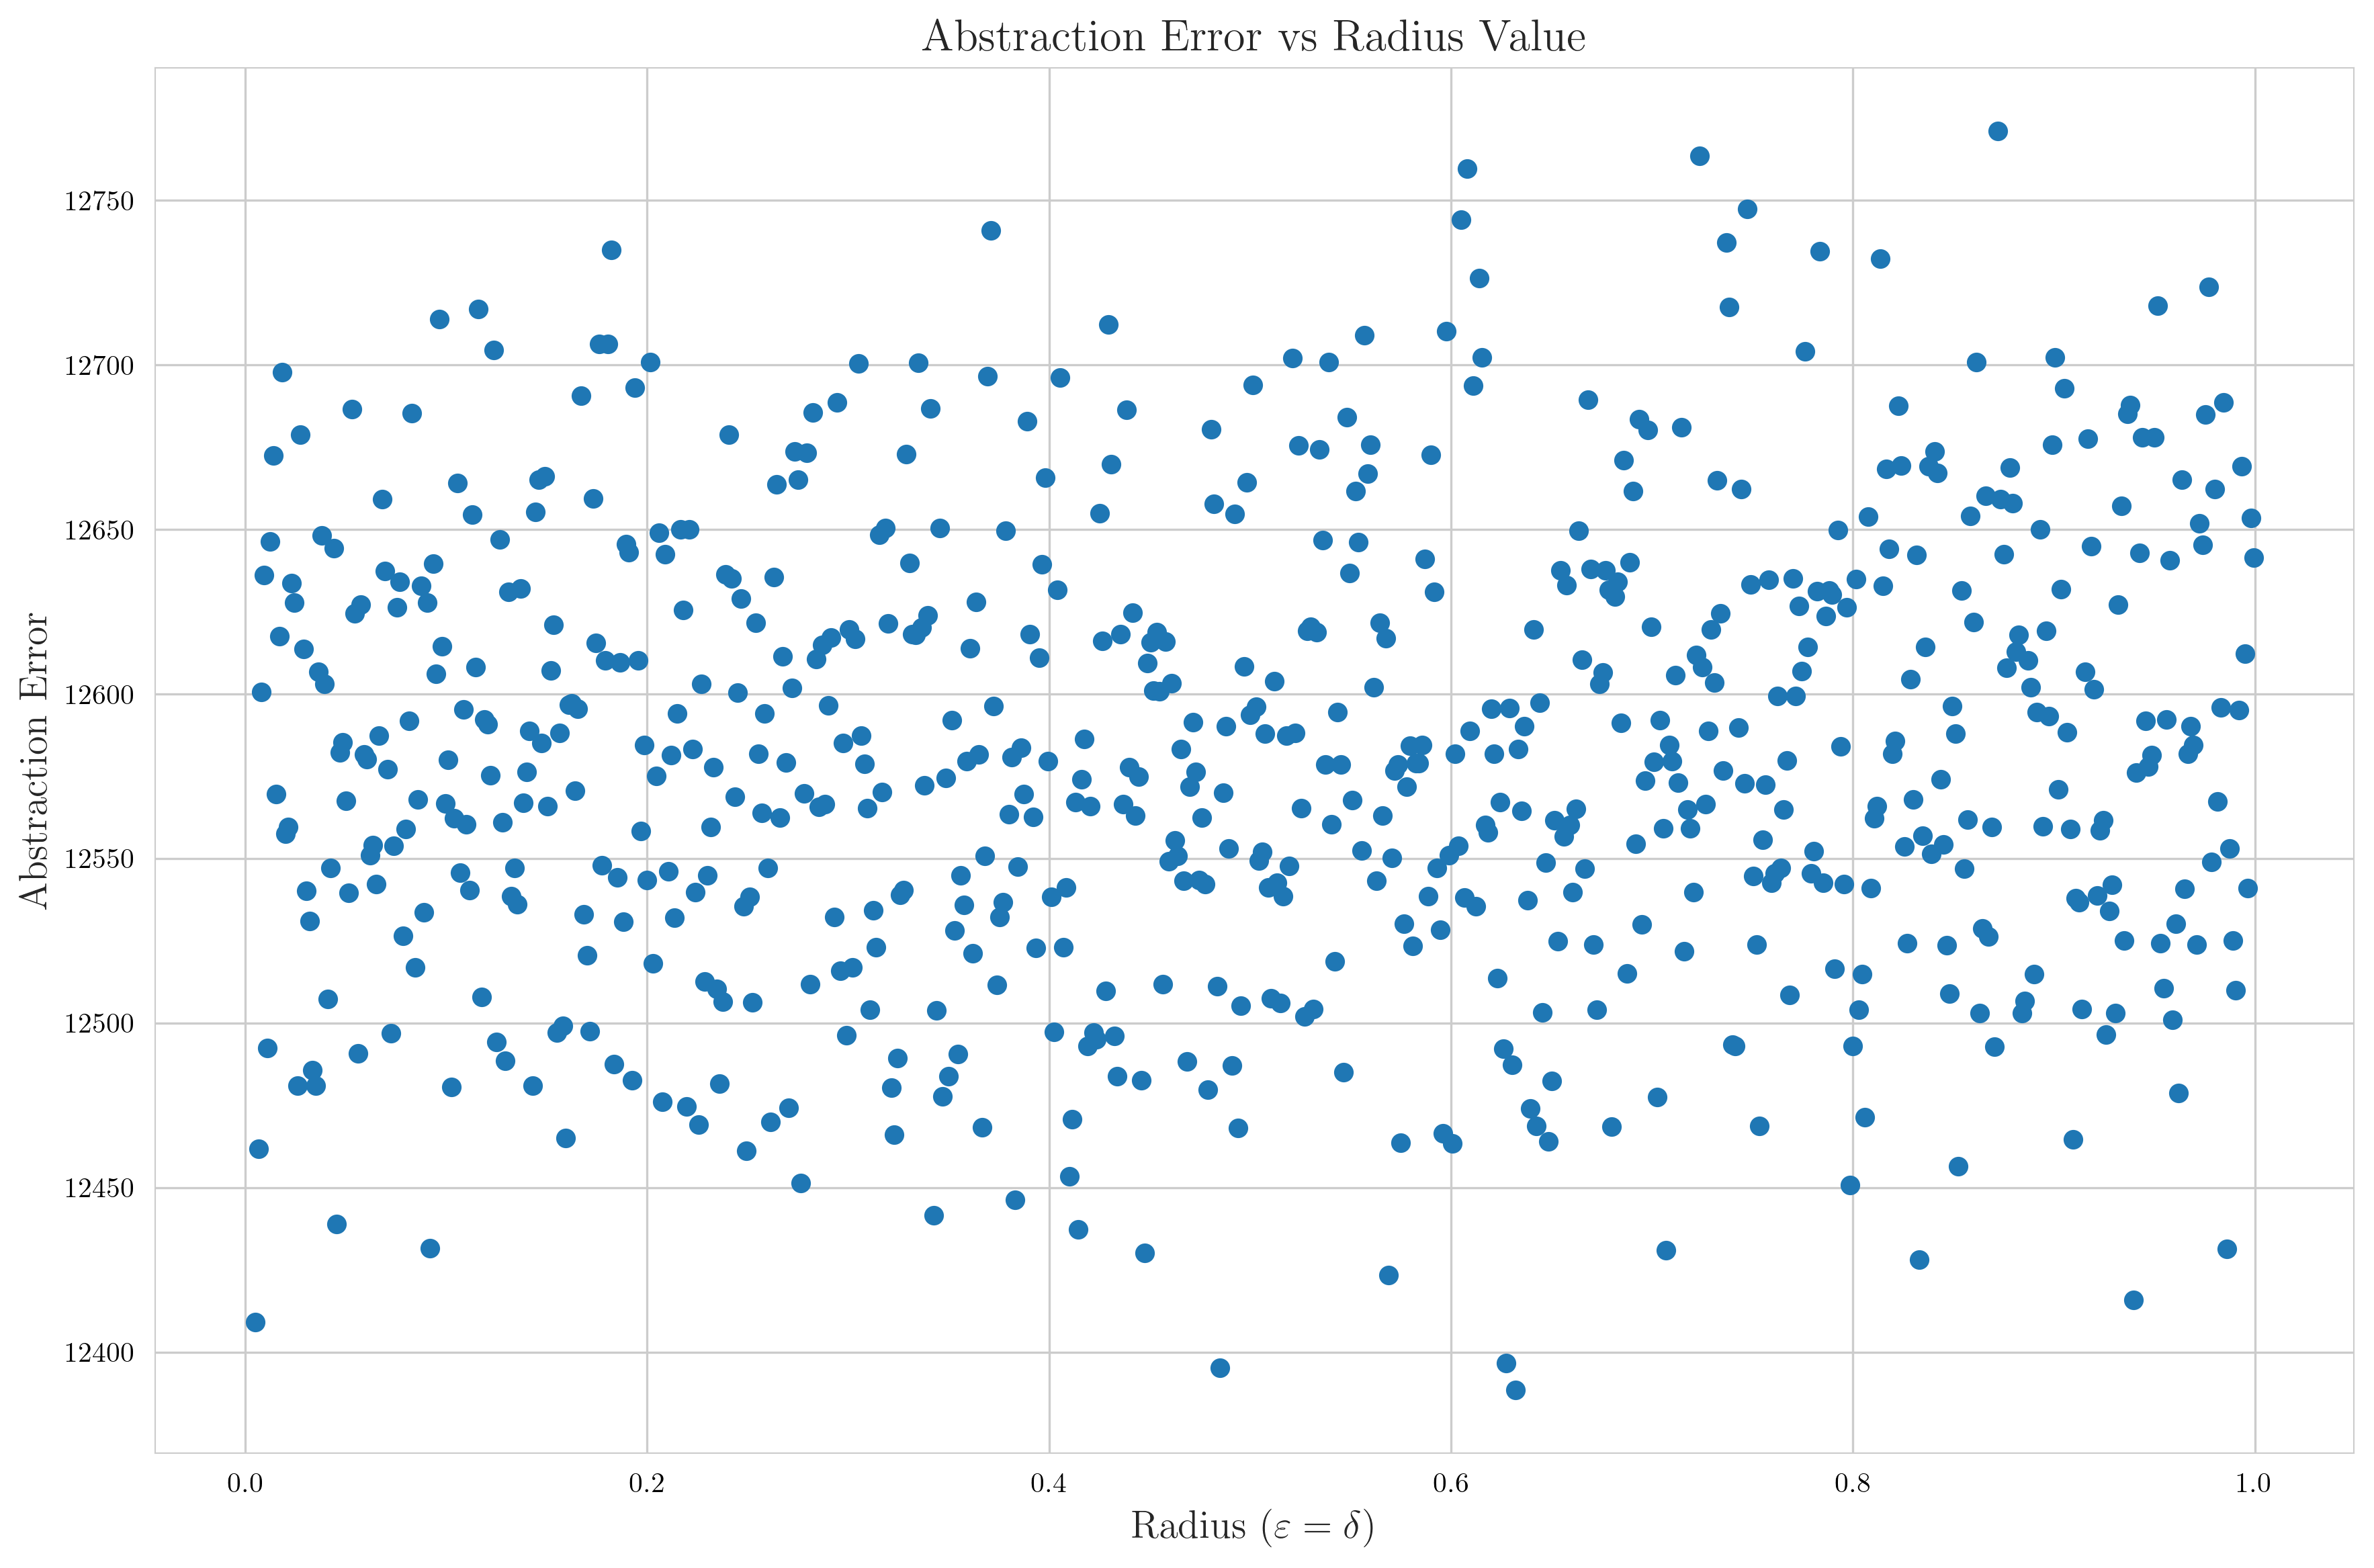


Best radius value:
Radius (ε=δ): 0.6320000000000002
Mean error: 12388.4010 ± 472.9590



In [123]:
pert_typeL = 'boundary_hat'
pert_typeH = 'boundary_hat'
tau = T_erica

for radius in [2, 3, 8, 12]:
    print(f"Radius: {radius}")
    
    
    params_erica, T_erica = oput.run_empirical_erica_optimization(**{**opt_params_erica, 'epsilon': radius, 'delta': radius})
   
    pwL = compute_empirical_worst_case_distance(params_erica['L'])
    pwH = compute_empirical_worst_case_distance(params_erica['H'])

    print(f"For L (epsilon): frobenius norm: {pwL}, radius_squared: {radius**2}, constraint satisfied: {pwL <= radius**2}")
    print(f"For H (delta): frobenius: {pwH}, radius_squared: {radius**2}, constraint satisfied: {pwH <= radius**2}")

    # Define the grid of radii to test
    radius_values = np.arange(.005, 1, .0015).tolist()  
    # Initialize arrays to store results
    error_values = np.zeros(len(radius_values))
    std_values   = np.zeros(len(radius_values))

    # Test each radius (using same value for L and H)
    for i, radius in enumerate(tqdm(radius_values)):
        abstraction_errors = []

        for _ in range(num_iter):
            pert_L = generate_pertubation(pert_typeL, 'L', experiment, rad=radius)
            pert_H = generate_pertubation(pert_typeH, 'H', experiment, rad=radius)

            total = 0
            for iota in test_data.keys():
                base, abst = test_data[iota]

                if add_pertL:
                    base = base + pert_L 
                if add_pertH:
                    abst = abst + pert_H 
                    
                base_norm = base / np.linalg.norm(base, 'fro')
                abst_norm = abst / np.linalg.norm(abst, 'fro')

                tau_base = base @ T_erica.T
                dist = evut.compute_empirical_distance(tau_base, abst, metric)
                total += dist
                            
            iter_avg = total / len(Ill)
            abstraction_errors.append(iter_avg)
        
        # Store mean and std for this radius
        error_values[i] = np.mean(abstraction_errors)
        std_values[i] = np.std(abstraction_errors)
        
        # Create 2D plot
    plt.figure(figsize=(12, 8))
    plt.plot(radius_values, error_values, 'o')
    #plt.plot([x**2 for x in radius_values], error_values, 'o')

    plt.xlabel(r'Radius ($\varepsilon=\delta$)')  # Using LaTeX notation
    plt.ylabel('Abstraction Error')
    plt.title('Abstraction Error vs Radius Value')
    plt.tight_layout()
    plt.show()

    # Print best radius
    best_idx = np.argmin(error_values)
    print("\nBest radius value:")
    print(f"Radius (ε=δ): {radius_values[best_idx]}")
    print(f"Mean error: {error_values[best_idx]:.4f} ± {std_values[best_idx]*1.96:.4f}")
    print( )

### Abstraction error vs Condition number

In [86]:
# # Create lists to store the values
# methods_list = list(methods.keys())
# #abstraction_errors = [final_abstraction_error[method][0] for method in methods_list]  # Get mean errors
# abstraction_errors = [min(abstraction_error[method]) for method in methods_list]
# condition_numbers = [condition_nums[method] for method in methods_list]

# # Create the scatter plot
# plt.figure(figsize=(10, 6))

# # Plot points
# plt.scatter(abstraction_errors, condition_numbers, alpha=0.6)

# # Add labels for each point
# for i, method in enumerate(methods_list):
#     plt.annotate(method.replace('_', ' '), 
#                 (abstraction_errors[i], condition_numbers[i]),
#                 xytext=(5, 5), textcoords='offset points')

# # Add labels and title
# plt.xlabel('Abstraction Error')
# plt.ylabel('Condition Number')
# plt.title('Abstraction Error vs Condition Number')

# # Add grid
# plt.grid(True, linestyle='--', alpha=0.7)

# # Optional: Set log scale for y-axis if condition numbers vary widely
# plt.yscale('log')

# # Adjust layout to prevent label clipping
# plt.tight_layout()

# plt.show()

# # Optionally, print the values in a table format
# print("\nMethod\t\tAbstraction Error\tCondition Number")
# print("-" * 50)
# for method in methods_list:
#     print(f"{method:<15} {final_abstraction_error[method][0]:>10.3f}\t\t{condition_nums[method]:>10.3f}")

In [18]:
import numpy as np
from scipy.stats import truncnorm, dirichlet

def truncated_normal(mean, std, lower, upper, size):
    """Generate samples from a truncated normal distribution."""
    a, b = (lower - mean) / std, (upper - mean) / std  # Convert to standard normal bounds
    return truncnorm.rvs(a, b, loc=mean, scale=std, size=size)

def generate_gmm(K, d, mean_range, var_range, weight_alpha=1.0):
    """
    Generate parameters for a GMM with constrained means and diagonal covariances.
    
    Args:
        K (int): Number of mixture components.
        d (int): Dimensionality of each Gaussian.
        mean_range (tuple): (lower, upper) bound for mean vectors.
        var_range (tuple): (lower, upper) bound for diagonal variances.
        weight_alpha (float): Parameter for Dirichlet prior on mixing weights.

    Returns:
        pi (array): Mixture weights (K,).
        mus (array): Mean vectors (K, d).
        sigmas (array): Diagonal variances (K, d).
    """
    a, b = mean_range
    var_min, var_max = var_range

    # Sample means within the specified range
    mus = np.array([truncated_normal(mean=(a+b)/2, std=(b-a)/6, lower=a, upper=b, size=d) for _ in range(K)])
    
    # Sample diagonal variances within the specified range
    sigmas = np.random.uniform(var_min, var_max, size=(K, d))

    # Sample mixing weights from a Dirichlet distribution
    pi = dirichlet.rvs([weight_alpha] * K)[0]  # Ensures sum(pi) = 1

    return pi, mus, sigmas

# Example usage
K, d = 3, 2  # 3 components, 2D Gaussians
mean_range = (-5, 5)  # Means in [-5, 5]
var_range = (0.5, 2.0)  # Diagonal variances in [0.5, 2.0]

pi, mus, sigmas = generate_gmm(K, d, mean_range, var_range)
print("Mixture Weights:", pi)
print("Mean Vectors:\n", mus)
print("Diagonal Variances:\n", sigmas)


Mixture Weights: [0.03546008 0.71850494 0.24603498]
Mean Vectors:
 [[ 0.69060898 -1.91968116]
 [-0.74487086 -1.54436782]
 [ 0.82580969 -0.56449051]]
Diagonal Variances:
 [[1.20929779 1.45480137]
 [1.10996571 1.54853104]
 [0.67626316 1.70916315]]
